# Exploring a IMDb K-Drama/Shows Dataset

This dataset contains information of Korean dramas and shows on the IMDb website. The data is from Kaggle (https://www.kaggle.com/datasets/chanoncharuchinda/imdb-korean-tv-series?select=koreanTV.csv) and was scrapped on Saturday December 11, 2021.

A quick look of this dataset shows that it contains dramas/shows whose country of origin contains "South Korea" on the IMDb website. 

Hence, some shows in the dataset are actually not K-drama. These shows are mostly cartoon/animation, such as "Teenage Mutant Ninja Turtles", "The Transformers".

The main goal of the analyses here are:
* Understand the dataset and perform any necessary data cleaning
* Explore distributions of each variable (e.g., ratings, genres)
* Investigate relationships between ratings of K-dramas/shows and other variables (e.g., aired lengh, episodie length)
* What is the most common genre in this dataset?
* Who stars in the most K-dramas/shows in this dataset?
* What are the most frequent words in the synopsis amoung high-rating K-dramas/shows?

Results of the current analyses may serve as the foundation for an application for K-drama recommendation



In [261]:
import pandas as pd
import numpy as np
import re
from pathlib import Path

from scipy.stats import iqr
from scipy.stats import pearsonr
import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

from wordcloud import WordCloud, STOPWORDS
# import nltk
# import string
# from nltk import word_tokenize
# from nltk.corpus import stopwords

import spacy

## 1.Understanding the Data

In [262]:
# Load the data
data_raw = pd.read_csv('data/koreanTV.csv')
data_raw

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story
0,Hellbound,(2021– ),6.7,"14,032",150 min,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",\nPeople hear predictions on when they will di...
1,Squid Game,(2021– ),8.1,"339,931",55 min,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",\nHundreds of cash-strapped players accept a s...
2,My Name,(2021– ),7.9,"12,877",50 min,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",\nThe story about a woman who joins an organiz...
3,Miraculous: Tales of Ladybug & Cat Noir,(2015– ),7.7,"9,439",20 min,"Animation, Action, Adventure","Cristina Valenzuela, Bryce Papenbrook, Keith S...","\nMarinette and Adrien, two normal teens, tran..."
4,Happiness,(2021– ),8.6,921,-,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",\nAn apocalyptic thriller that takes place in ...
...,...,...,...,...,...,...,...,...
1984,Untitled K-Pop Latin American Project,NaN,-,-,-,Reality-TV,-,\nYoung men from Latin America audition for an...
1985,Bite Sisters,(2021),7.4,5,-,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",\nThis story follows Han Yi Na a vampire who s...
1986,Adult Trainee,(2021– ),7.1,10,-,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",\nAdd a Plot\n
1987,A good supper,(2021),-,-,-,Romance,-,\nAdd a Plot\n


In [263]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        1989 non-null   object
 1   Year         1978 non-null   object
 2   Rating       1989 non-null   object
 3   Votes:       1989 non-null   object
 4   Time         1989 non-null   object
 5   Genre        1989 non-null   object
 6   Stars        1989 non-null   object
 7   Short Story  1989 non-null   object
dtypes: object(8)
memory usage: 124.4+ KB


In [264]:
# Show unique values in each column, excluding the column "Title" and "Short Story"
cols = data_raw.drop(['Short Story'],axis=1).columns.tolist()
uniqVal_raw = pd.DataFrame(columns=['Variable','nUniq','UniqVal'])
for i,col in enumerate(cols):
    _arr = np.array(
        [col, 
         data_raw[col].nunique(), 
         data_raw[col].unique()],
        dtype='object'
    )
    uniqVal_raw.loc[i,:] = _arr

uniqVal_raw

,Variable,nUniq,UniqVal
0,Title,1975,"[Hellbound, Squid Game, My Name, Miraculous: T..."
1,Year,173,"[(2021– ), (2015– ), (2010–2018), (2019– ), (2..."
2,Rating,62,"[6.7, 8.1, 7.9, 7.7, 8.6, 6.9, 8.4, 7.4, 8.7, ..."
3,Votes:,659,"[14,032, 339,931, 12,877, 9,439, 921, 1,031, 8..."
4,Time,79,"[150 min, 55 min, 50 min, 20 min, -, 60 min, 1..."
5,Genre,224,"[Crime, Drama, Fantasy, Action, Drama, Mystery..."
6,Stars,1445,"[Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-..."


**Interim Summary:**
* Missing values in some columns are represented as "-". Replace them with NaN
* Replace "\nAdd a Plot\n" in the Short Story column with NaN. 
* The format of the "year" data needs to be cleaned
* Need to transform the following columns to numeric data type: rating, votes, time
* There are 1989 rows (data points) in the data but there are only 1975 unique titles, indicating that there may be shows with the same title in the data
* This dataset contains animation/cartoons, which may not be the K-drama we typically think of. Remove them for the current anlaysis.

## 2.Data Cleaning

### 2.1 Replace missing values with NaN

In [265]:
for col in data_raw.columns:
    data_raw.loc[data_raw[col] == '-', col] = np.nan
    
data_raw

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story
0,Hellbound,(2021– ),6.7,"14,032",150 min,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",\nPeople hear predictions on when they will di...
1,Squid Game,(2021– ),8.1,"339,931",55 min,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",\nHundreds of cash-strapped players accept a s...
2,My Name,(2021– ),7.9,"12,877",50 min,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",\nThe story about a woman who joins an organiz...
3,Miraculous: Tales of Ladybug & Cat Noir,(2015– ),7.7,"9,439",20 min,"Animation, Action, Adventure","Cristina Valenzuela, Bryce Papenbrook, Keith S...","\nMarinette and Adrien, two normal teens, tran..."
4,Happiness,(2021– ),8.6,921,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",\nAn apocalyptic thriller that takes place in ...
...,...,...,...,...,...,...,...,...
1984,Untitled K-Pop Latin American Project,NaN,NaN,NaN,NaN,Reality-TV,NaN,\nYoung men from Latin America audition for an...
1985,Bite Sisters,(2021),7.4,5,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",\nThis story follows Han Yi Na a vampire who s...
1986,Adult Trainee,(2021– ),7.1,10,NaN,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",\nAdd a Plot\n
1987,A good supper,(2021),NaN,NaN,NaN,Romance,NaN,\nAdd a Plot\n


In [266]:
# The "\nAdd a Plot\n" in the Short Story column means missing values
data_raw.loc[data_raw['Short Story'] == "\nAdd a Plot\n", 'Short Story'] = np.nan
data_raw

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story
0,Hellbound,(2021– ),6.7,"14,032",150 min,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",\nPeople hear predictions on when they will di...
1,Squid Game,(2021– ),8.1,"339,931",55 min,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",\nHundreds of cash-strapped players accept a s...
2,My Name,(2021– ),7.9,"12,877",50 min,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",\nThe story about a woman who joins an organiz...
3,Miraculous: Tales of Ladybug & Cat Noir,(2015– ),7.7,"9,439",20 min,"Animation, Action, Adventure","Cristina Valenzuela, Bryce Papenbrook, Keith S...","\nMarinette and Adrien, two normal teens, tran..."
4,Happiness,(2021– ),8.6,921,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",\nAn apocalyptic thriller that takes place in ...
...,...,...,...,...,...,...,...,...
1984,Untitled K-Pop Latin American Project,NaN,NaN,NaN,NaN,Reality-TV,NaN,\nYoung men from Latin America audition for an...
1985,Bite Sisters,(2021),7.4,5,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",\nThis story follows Han Yi Na a vampire who s...
1986,Adult Trainee,(2021– ),7.1,10,NaN,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",NaN
1987,A good supper,(2021),NaN,NaN,NaN,Romance,NaN,NaN


### 2.2 Clean the Year column

#### 2.2.1. Clean (I) or (II) in the year values

In [267]:
# Look into the "Year" column
data_raw['Year'].unique()

array(['(2021– )', '(2015– )', '(2010–2018)', '(2019– )', '(2020– )',
       '(2019–2020)', '(2020)', '(2016–2017)', '(2007–2015)',
       '(2020–2021)', '(2005–2014)', '(2018)', '(2002–2007)', '(2017– )',
       '(2019)', '(2016)', '(2021)', '(2017)', '(2015–2016)',
       '(1987–1996)', '(2018– )', '(2022– )', '(2003–2010)', '(2009)',
       '(2017–2018)', '(2013–2014)', '(2013)', '(2018–2019)',
       '(1984–1987)', '(2014–2015)', '(2017–2021)', '(2019–2021)',
       '(2003–2005)', '(2010– )', '(1991–1995)', '(2016–2018)',
       '(2017–2019)', '(2016–2020)', '(2008–2010)', '(2015)',
       '(2010–2011)', '(2007)', '(1988–1990)', '(2001–2014)', '(2014)',
       '(2011)', '(1993–1996)', '(2012)', '(2016–2021)', '(2011–2012)',
       '(2006–2019)', '(2018–2021)', '(2004–2008)', '(2021–2022)',
       '(2003–2004)', '(2009–2013)', '(I) (2019–2020)', '(1993–1994)',
       '(2010)', '(2007–2010)', '(2001–2003)', '(2004)', '(2009–2012)',
       '(2005)', '(2011–2022)', '(2016– )', '(2014– 

In [268]:
# Some shows have year values containing "(I)" or "(II)", which may indicate seasons of the show
# Need to remove them and store in a separate column

# A quick look at these shows
idx  = data_raw['Year'].str.contains(pat="\([A-Za-z]+\)", regex=True, na=False)
data_raw.loc[idx].sort_values('Title')

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story
1879,9 Seconds: Eternal Time,(I) (2015),7.0,11,15 min,Drama,NaN,\nWith a magic camera that gives them the powe...
213,Chocolate,(I) (2019–2020),7.7,"1,042",70 min,"Drama, Romance","Ha Ji-Won, Yoon Kyesang, Seung-jo Jang, Jin-Wo...","\nLee Kang is a neurosurgeon, who once dreamed..."
1371,Coma,(I) (2006– ),7.0,54,NaN,Horror,"Se-eun Lee, So-Yean Bae, Su-yeon Cha, Jung-Ha ...",\nIt is a horror-mystery film set in a hospita...
1773,Fantastic Duo,(II) (2017– ),NaN,NaN,NaN,Musical,NaN,NaN
1692,Next,(II) (2005),NaN,NaN,60 min,History,NaN,\nIn an epic story of star-crossed lovers that...
1580,Paboo & Mojies,(II) (2012–2019),NaN,NaN,NaN,"Animation, Action, Adventure",NaN,\nPaboo is a young yet curious panda boy who l...
1762,Paboo & Mojies,(I) (2012–2013),NaN,NaN,NaN,"Animation, Adventure, Comedy",NaN,\nPaboo is a young yet curious panda boy who l...
795,Running Man,(I) (2017–2019),8.0,29,NaN,"Animation, Comedy","Carrie Savage, Matthew Ip Shaw, Daniel J. Edwa...",\nThe fruit of the Soul Tree was the source of...
793,Spark,(II) (2016),6.9,54,14 min,Drama,"Na In-Woo, Bo-ra Nam, Yeo One",\nStrange things happen at night. Son Ha Neul ...
1721,The Guardian,(II) (2017),NaN,NaN,NaN,Drama,NaN,NaN


In [269]:
# Extract the "Season" information from "Year" and add it to a new "Season" column
data_raw = data_raw.assign(
    Season=data_raw.loc[idx, 'Year'].str.extract("(\([A-Za-z]+\))")    
)
data_raw.loc[idx]

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story,Season
213,Chocolate,(I) (2019–2020),7.7,"1,042",70 min,"Drama, Romance","Ha Ji-Won, Yoon Kyesang, Seung-jo Jang, Jin-Wo...","\nLee Kang is a neurosurgeon, who once dreamed...",(I)
793,Spark,(II) (2016),6.9,54,14 min,Drama,"Na In-Woo, Bo-ra Nam, Yeo One",\nStrange things happen at night. Son Ha Neul ...,(II)
795,Running Man,(I) (2017–2019),8.0,29,NaN,"Animation, Comedy","Carrie Savage, Matthew Ip Shaw, Daniel J. Edwa...",\nThe fruit of the Soul Tree was the source of...,(I)
990,Untouchable,(II) (2017– ),7.4,54,NaN,Drama,"Eun-ji Jung, Jae-ryong Cho, Yoon-Ha Ji, Soo-ji...",\nThe city of Bukcheon has been dominated by t...,(II)
1371,Coma,(I) (2006– ),7.0,54,NaN,Horror,"Se-eun Lee, So-Yean Bae, Su-yeon Cha, Jung-Ha ...",\nIt is a horror-mystery film set in a hospita...,(I)
1580,Paboo & Mojies,(II) (2012–2019),NaN,NaN,NaN,"Animation, Action, Adventure",NaN,\nPaboo is a young yet curious panda boy who l...,(II)
1692,Next,(II) (2005),NaN,NaN,60 min,History,NaN,\nIn an epic story of star-crossed lovers that...,(II)
1721,The Guardian,(II) (2017),NaN,NaN,NaN,Drama,NaN,NaN,(II)
1762,Paboo & Mojies,(I) (2012–2013),NaN,NaN,NaN,"Animation, Adventure, Comedy",NaN,\nPaboo is a young yet curious panda boy who l...,(I)
1773,Fantastic Duo,(II) (2017– ),NaN,NaN,NaN,Musical,NaN,NaN,(II)


In [270]:
# Remove "(I)" or "(II)" from the year vales
data_raw['Year'] = data_raw['Year'].str.replace("(\([A-Za-z]+\))", '', regex=True)
data_raw.loc[idx]

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story,Season
213,Chocolate,(2019–2020),7.7,"1,042",70 min,"Drama, Romance","Ha Ji-Won, Yoon Kyesang, Seung-jo Jang, Jin-Wo...","\nLee Kang is a neurosurgeon, who once dreamed...",(I)
793,Spark,(2016),6.9,54,14 min,Drama,"Na In-Woo, Bo-ra Nam, Yeo One",\nStrange things happen at night. Son Ha Neul ...,(II)
795,Running Man,(2017–2019),8.0,29,NaN,"Animation, Comedy","Carrie Savage, Matthew Ip Shaw, Daniel J. Edwa...",\nThe fruit of the Soul Tree was the source of...,(I)
990,Untouchable,(2017– ),7.4,54,NaN,Drama,"Eun-ji Jung, Jae-ryong Cho, Yoon-Ha Ji, Soo-ji...",\nThe city of Bukcheon has been dominated by t...,(II)
1371,Coma,(2006– ),7.0,54,NaN,Horror,"Se-eun Lee, So-Yean Bae, Su-yeon Cha, Jung-Ha ...",\nIt is a horror-mystery film set in a hospita...,(I)
1580,Paboo & Mojies,(2012–2019),NaN,NaN,NaN,"Animation, Action, Adventure",NaN,\nPaboo is a young yet curious panda boy who l...,(II)
1692,Next,(2005),NaN,NaN,60 min,History,NaN,\nIn an epic story of star-crossed lovers that...,(II)
1721,The Guardian,(2017),NaN,NaN,NaN,Drama,NaN,NaN,(II)
1762,Paboo & Mojies,(2012–2013),NaN,NaN,NaN,"Animation, Adventure, Comedy",NaN,\nPaboo is a young yet curious panda boy who l...,(I)
1773,Fantastic Duo,(2017– ),NaN,NaN,NaN,Musical,NaN,NaN,(II)


#### 2.2.2. Create a new column storing the released year and a column storing the length in years a show is aired
Some shows are aired across multiple years. 

Create a column indicating the year a show is first released and another column indicating how many years a show is played.

In [271]:
years = []
year_release = []
n_years = []
for idx, value in data_raw['Year'].iteritems():
    if pd.isnull(value):
        # Put NaN for missing values
        years.append(np.nan)
        year_release.append(np.nan)
        n_years.append(np.nan)
    else:
        # Find all years (string of 4-digit number)
        ys = re.findall("[0-9]{4}", value)
        # Convert to numerical values
        ys = [int(y) for y in ys if y.isdigit]
        # Sort it by years 
        ys = sorted(ys)
        # Store the list into a big list
        years.append(ys)
        
        # Store the released year
        year_release.append(ys[0])
        
        # Calculate the number of years
        n_years.append(ys[-1] - ys[0])

# Add new columns
data_raw = data_raw.assign(
    Years_list=years,
    YearRelease=year_release,
    nYears=n_years
)

data_raw

,Title,Year,Rating,Votes:,Time,Genre,Stars,Short Story,Season,Years_list,YearRelease,nYears
0,Hellbound,(2021– ),6.7,"14,032",150 min,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",\nPeople hear predictions on when they will di...,NaN,[2021],2021.0,0.0
1,Squid Game,(2021– ),8.1,"339,931",55 min,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",\nHundreds of cash-strapped players accept a s...,NaN,[2021],2021.0,0.0
2,My Name,(2021– ),7.9,"12,877",50 min,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",\nThe story about a woman who joins an organiz...,NaN,[2021],2021.0,0.0
3,Miraculous: Tales of Ladybug & Cat Noir,(2015– ),7.7,"9,439",20 min,"Animation, Action, Adventure","Cristina Valenzuela, Bryce Papenbrook, Keith S...","\nMarinette and Adrien, two normal teens, tran...",NaN,[2015],2015.0,0.0
4,Happiness,(2021– ),8.6,921,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",\nAn apocalyptic thriller that takes place in ...,NaN,[2021],2021.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1984,Untitled K-Pop Latin American Project,NaN,NaN,NaN,NaN,Reality-TV,NaN,\nYoung men from Latin America audition for an...,NaN,NaN,NaN,NaN
1985,Bite Sisters,(2021),7.4,5,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",\nThis story follows Han Yi Na a vampire who s...,NaN,[2021],2021.0,0.0
1986,Adult Trainee,(2021– ),7.1,10,NaN,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",NaN,NaN,[2021],2021.0,0.0
1987,A good supper,(2021),NaN,NaN,NaN,Romance,NaN,NaN,NaN,[2021],2021.0,0.0


### 2.3 Clean and convert some columns to numeric types
* Rating
* Votes:
* Time

In [272]:
# Rating
data_raw = data_raw.astype({'Rating': 'float64'})

In [273]:
# Votes
# Rename the column such that ":" is removed
data_raw = data_raw.rename(columns={'Votes:': 'Votes'})

# Need to first remove "," and convert to numercial data type
# Cannot convert to integer since there are NaNs
data_raw['Votes'] = data_raw['Votes'].str.replace(',','').astype('float64')

In [274]:
# Time
# Remove "min" and convert to numerical data type
data_raw['Time'] = data_raw['Time'].str.replace('min','').astype('float64')

In [275]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1989 entries, 0 to 1988
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        1989 non-null   object 
 1   Year         1978 non-null   object 
 2   Rating       1485 non-null   float64
 3   Votes        1485 non-null   float64
 4   Time         1068 non-null   float64
 5   Genre        1903 non-null   object 
 6   Stars        1447 non-null   object 
 7   Short Story  1662 non-null   object 
 8   Season       11 non-null     object 
 9   Years_list   1978 non-null   object 
 10  YearRelease  1978 non-null   float64
 11  nYears       1978 non-null   float64
dtypes: float64(5), object(7)
memory usage: 186.6+ KB


### 2.4 Clean the Short Story column
Remove "\n" at the beginning and the end of the sentnece

In [276]:
data_raw['Short Story'] = data_raw['Short Story'].str.strip()
data_raw['Short Story']

0       People hear predictions on when they will die....
1       Hundreds of cash-strapped players accept a str...
2       The story about a woman who joins an organized...
3       Marinette and Adrien, two normal teens, transf...
4       An apocalyptic thriller that takes place in a ...
                              ...                        
1984    Young men from Latin America audition for an o...
1985    This story follows Han Yi Na a vampire who sud...
1986                                                  NaN
1987                                                  NaN
1988                                                  NaN
Name: Short Story, Length: 1989, dtype: object

### 2.5 Check for duplicate data points

In [277]:
# When only check for duplicate titles
data_raw.loc[data_raw.duplicated(subset=['Title'], keep=False)].sort_values('Title')

,Title,Year,Rating,Votes,Time,Genre,Stars,Short Story,Season,Years_list,YearRelease,nYears
1781,Family Outing,(2010– ),NaN,NaN,70.0,"Comedy, Game-Show, Reality-TV",NaN,NaN,NaN,[2010],2010.0,0.0
1013,Family Outing,(2008–2010),8.7,165.0,80.0,Game-Show,"Jae-Suk Yoo, Hyo-ri Lee, Jong-shin Yoon, Soo-R...",A South Korea Variety Show. It consists of a p...,NaN,"[2008, 2010]",2008.0,2.0
587,Happy Together,(1999– ),7.4,35.0,65.0,"Comedy, Drama, Romance","Lee Byung-hun, Tae-Hyun Cha, Jun Ji-hyun, Min-...",Happy Together is a hugely successful melodram...,NaN,[1999],1999.0,0.0
1941,Happy Together,(2007– ),NaN,NaN,80.0,Reality-TV,NaN,"""Happy Together"" is a popular South Korean rea...",NaN,[2007],2007.0,0.0
910,Happy Together,(2001–2020),7.4,30.0,95.0,"Comedy, Talk-Show","Kyung-Hwan Heo, Yoon Shi-Yoon, Tae-Hyun Cha, S...",Happy Together is a South Korean talk show whi...,NaN,"[2001, 2020]",2001.0,19.0
1877,Iljimae,(1993– ),7.9,19.0,NaN,"Adventure, Action, Drama","Jang Dong-Gun, Jung-ah Yum, Kyung-wok Im",NaN,NaN,[1993],1993.0,0.0
380,Iljimae,(2008),8.1,902.0,60.0,"Action, History, Romance","Lee Joon-Gi, Sung-ryung Kim, Kil-kang Ahn, Won...","During the Joseon Dynasty, Ryung acted as a ho...",NaN,[2008],2008.0,0.0
1641,Love Letter,(2004–2007),NaN,NaN,60.0,Game-Show,NaN,Real Romance Love Letter was a South Korean te...,NaN,"[2004, 2007]",2004.0,3.0
1458,Love Letter,(2003– ),7.1,48.0,60.0,Drama,"Su-hyeon Seong, Yoo Seung-ho, Soo Ae, Son Hyeo...","Lee Woo-Jin, also known as Andrew (Jo Hyeon-Ja...",NaN,[2003],2003.0,0.0
1762,Paboo & Mojies,(2012–2013),NaN,NaN,NaN,"Animation, Adventure, Comedy",NaN,Paboo is a young yet curious panda boy who liv...,(I),"[2012, 2013]",2012.0,1.0


In [278]:
# The results above show that some shows have identical title but are actually different shows because their genre and synopses (Short Story) are different
# Thus, we should also consider the synopsis when looking for duplicate shows
data_raw.loc[data_raw.duplicated(subset=['Title','Short Story'], keep=False)].sort_values('Title')

,Title,Year,Rating,Votes,Time,Genre,Stars,Short Story,Season,Years_list,YearRelease,nYears
1580,Paboo & Mojies,(2012–2019),NaN,NaN,NaN,"Animation, Action, Adventure",NaN,Paboo is a young yet curious panda boy who liv...,(II),"[2012, 2019]",2012.0,7.0
1762,Paboo & Mojies,(2012–2013),NaN,NaN,NaN,"Animation, Adventure, Comedy",NaN,Paboo is a young yet curious panda boy who liv...,(I),"[2012, 2013]",2012.0,1.0


In [279]:
# When considering both the title and synopsis, only one duplicate show is found
# It appears the show with Season "(I)" label can be replaced by the counterpart with "(II)" label because the time it's aired is shorter and overlaps with the other one
idxNum_rm = 1762

In [280]:
# Remove that duplicate show
data_raw = data_raw.drop(idxNum_rm)

### 2.6 Extract data from columns that will be used

In [281]:
# Since there are only a few shows that have Season information, ignore the Season information for simplicity
cols = ['Title','YearRelease','nYears','Rating','Votes','Time','Genre','Stars','Short Story']
data = data_raw[cols]

data

,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
0,Hellbound,2021.0,0.0,6.7,14032.0,150.0,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",People hear predictions on when they will die....
1,Squid Game,2021.0,0.0,8.1,339931.0,55.0,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",Hundreds of cash-strapped players accept a str...
2,My Name,2021.0,0.0,7.9,12877.0,50.0,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",The story about a woman who joins an organized...
3,Miraculous: Tales of Ladybug & Cat Noir,2015.0,0.0,7.7,9439.0,20.0,"Animation, Action, Adventure","Cristina Valenzuela, Bryce Papenbrook, Keith S...","Marinette and Adrien, two normal teens, transf..."
4,Happiness,2021.0,0.0,8.6,921.0,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",An apocalyptic thriller that takes place in a ...
...,...,...,...,...,...,...,...,...,...
1984,Untitled K-Pop Latin American Project,NaN,NaN,NaN,NaN,NaN,Reality-TV,NaN,Young men from Latin America audition for an o...
1985,Bite Sisters,2021.0,0.0,7.4,5.0,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",This story follows Han Yi Na a vampire who sud...
1986,Adult Trainee,2021.0,0.0,7.1,10.0,NaN,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",NaN
1987,A good supper,2021.0,0.0,NaN,NaN,NaN,Romance,NaN,NaN


### 2.7 Remove shows that are animation/cartoons

In [282]:
idx = data['Genre'].str.contains('Animation', na=False)
print("{} shows have labels of 'Animation'".format(data.loc[idx].shape[0]))
print("Remove them")
data = data.loc[~idx]
data

185 shows have labels of 'Animation'
Remove them


,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
0,Hellbound,2021.0,0.0,6.7,14032.0,150.0,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",People hear predictions on when they will die....
1,Squid Game,2021.0,0.0,8.1,339931.0,55.0,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",Hundreds of cash-strapped players accept a str...
2,My Name,2021.0,0.0,7.9,12877.0,50.0,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",The story about a woman who joins an organized...
4,Happiness,2021.0,0.0,8.6,921.0,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",An apocalyptic thriller that takes place in a ...
5,Dr. Brain,2021.0,0.0,6.9,1031.0,60.0,"Drama, Mystery, Sci-Fi","Sun-kyun Lee, June Yoon, Yoo-Young Lee, Hee-so...",Brilliant brain scientist Sewon (Lee Sun-Kyun)...
...,...,...,...,...,...,...,...,...,...
1984,Untitled K-Pop Latin American Project,NaN,NaN,NaN,NaN,NaN,Reality-TV,NaN,Young men from Latin America audition for an o...
1985,Bite Sisters,2021.0,0.0,7.4,5.0,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",This story follows Han Yi Na a vampire who sud...
1986,Adult Trainee,2021.0,0.0,7.1,10.0,NaN,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",NaN
1987,A good supper,2021.0,0.0,NaN,NaN,NaN,Romance,NaN,NaN


### 2.8 Add unique id column

In [283]:
# Since there are dramas/shows with identical titles, create a new column indicating unique id of each drama/show
data = data.reset_index().rename(columns={'index':'id'})
data

,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
0,0,Hellbound,2021.0,0.0,6.7,14032.0,150.0,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",People hear predictions on when they will die....
1,1,Squid Game,2021.0,0.0,8.1,339931.0,55.0,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",Hundreds of cash-strapped players accept a str...
2,2,My Name,2021.0,0.0,7.9,12877.0,50.0,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",The story about a woman who joins an organized...
3,4,Happiness,2021.0,0.0,8.6,921.0,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",An apocalyptic thriller that takes place in a ...
4,5,Dr. Brain,2021.0,0.0,6.9,1031.0,60.0,"Drama, Mystery, Sci-Fi","Sun-kyun Lee, June Yoon, Yoo-Young Lee, Hee-so...",Brilliant brain scientist Sewon (Lee Sun-Kyun)...
...,...,...,...,...,...,...,...,...,...,...
1798,1984,Untitled K-Pop Latin American Project,NaN,NaN,NaN,NaN,NaN,Reality-TV,NaN,Young men from Latin America audition for an o...
1799,1985,Bite Sisters,2021.0,0.0,7.4,5.0,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",This story follows Han Yi Na a vampire who sud...
1800,1986,Adult Trainee,2021.0,0.0,7.1,10.0,NaN,"Comedy, Romance","Mi-Yeon Cho, Ryu Eui-Hyun, Lee Chan Hyung, Yoo...",NaN
1801,1987,A good supper,2021.0,0.0,NaN,NaN,NaN,Romance,NaN,NaN


In [284]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1803 entries, 0 to 1802
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           1803 non-null   int64  
 1   Title        1803 non-null   object 
 2   YearRelease  1793 non-null   float64
 3   nYears       1793 non-null   float64
 4   Rating       1343 non-null   float64
 5   Votes        1343 non-null   float64
 6   Time         969 non-null    float64
 7   Genre        1717 non-null   object 
 8   Stars        1328 non-null   object 
 9   Short Story  1508 non-null   object 
dtypes: float64(5), int64(1), object(4)
memory usage: 141.0+ KB


## 3.Exploratory Analyses

In [472]:
# Set seaborn visualization style and context
sns.set_style('ticks')
sns.set_context('talk')

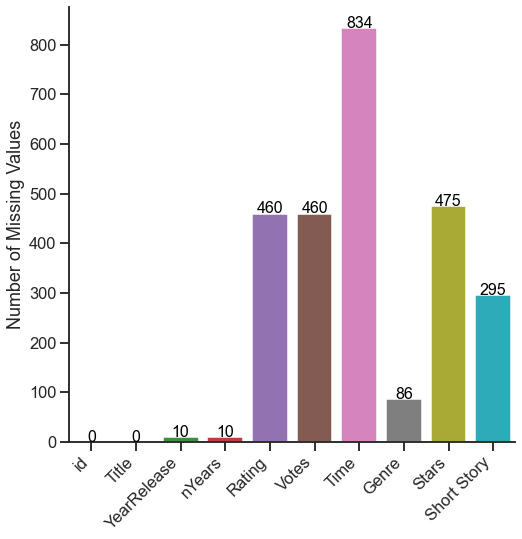

In [286]:
# Number of missing values in each variable
nMissVal = data.isnull().sum()

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(x=nMissVal.index, y=nMissVal.values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel("Number of Missing Values")

for i in range(len(nMissVal)):
    ax.text(
        i, (nMissVal[i]+0.5),
        str(nMissVal[i]),
        fontdict=dict(color='black',fontsize=16),
        horizontalalignment = 'center'
    )

sns.despine()
plt.show()

### 3.1 Descriptive statistics

In [287]:
# Numbercial variables
data.select_dtypes('number').drop(columns=['id']).describe()

,YearRelease,nYears,Rating,Votes,Time
count,1793.000000,1793.000000,1343.000000,1343.000000,969.000000
mean,2013.418851,0.290017,7.452941,941.970216,57.204334
std,5.913648,1.081808,0.781953,9504.066309,52.689696
min,1982.000000,0.000000,1.800000,5.000000,2.000000
25%,2010.000000,0.000000,7.000000,28.000000,35.000000
50%,2015.000000,0.000000,7.500000,88.000000,60.000000
75%,2018.000000,0.000000,8.000000,417.000000,65.000000
max,2022.000000,19.000000,10.000000,339931.000000,960.000000


In [288]:
# Categorical variables
data.select_dtypes(exclude='number').describe()

,Title,Genre,Stars,Short Story
count,1803,1717,1328,1508
unique,1793,194,1325,1508
top,Happy Together,Drama,"BTS, J-Hope, Jimin, Jin",People hear predictions on when they will die....
freq,3,303,3,1


### 3.2 Visualization of numerical variables

#### 3.2.1 Ratings

Mean of Rating: 7.45


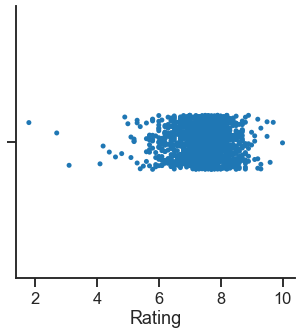

In [402]:
col = 'Rating'
print("Mean of {}: {:.2f}".format(col,data[col].mean()))

fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(data=data, x=col)
ax.set_xlabel('Rating')
sns.despine()
plt.show()

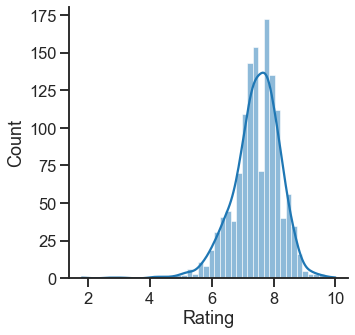

In [407]:
col = 'Rating'

fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=data, x=col, kde=True)
ax.set_xlabel('Rating')
sns.despine()
plt.show()

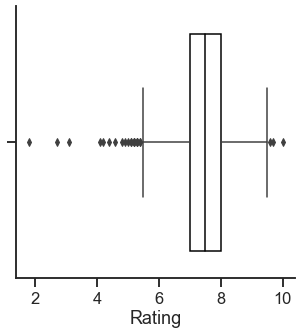

In [413]:
col = 'Rating'

fig, ax = plt.subplots(figsize=(5,5))
box = sns.boxplot(
      ax=ax, data=data, x=col,
      linewidth=1.5,
      boxprops=dict(facecolor='none', edgecolor='black'),
      medianprops=dict(color='black')
  )
ax.set_xlabel('Rating')
sns.despine()
plt.show()

In [414]:
# Rating
# Which shows have very high ratings that are considered as "outliers"?
col = 'Rating'

thresh_top = data[col].quantile(0.75) + 1.5 * iqr(data[col].dropna())
# thresh_bot = data[col].quantile(0.25) - 1.5 * iqr(data[col].dropna())

print("{}: Upper threshold for outlier is {:.2f}".format(col, thresh_top))
data.loc[data[col]>thresh_top]
data.loc[data[col]>thresh_top, ['Title','YearRelease','Rating','Votes','Genre','Stars','Short Story']]

Rating: Upper threshold for outlier is 9.50


,Title,YearRelease,Rating,Votes,Genre,Stars,Short Story
35,Snowdrop,2021.0,10.0,140.0,"Drama, Romance","Jung Hae-In, Jisoo Kim, Yoo In-Na, Lee Jung-hyun",Adapted from the handwritten notes of a man wh...
341,BTS: Bon Voyage,2016.0,9.6,908.0,Reality-TV,"BTS, J-Hope, Jimin, Jin",BTS: Bon Voyage is a reality show about member...
357,Run BTS!,2015.0,9.7,1013.0,Game-Show,"RM, V, Jin, Jimin",Run BTS (Dallyeola Bangtan!) is a South Korean...


In [405]:
# Rating
# Which shows have low ratings that are considered as "outliers"?
col = 'Rating'

# thresh_top = data[col].quantile(0.75) + 1.5 * iqr(data[col].dropna())
thresh_bot = data[col].quantile(0.25) - 1.5 * iqr(data[col].dropna())

print("{}: Lower threshold for outlier is {:.2f}".format(col, thresh_bot))
data.loc[data[col]<thresh_bot].sort_values(col).head(5)

Rating: Lower threshold for outlier is 5.50


,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
217,245,Racket Boys,2021.0,0.0,1.8,27231.0,80.0,"Comedy, Drama, Sport","Kim Sang-kyung, Na-ra Oh, Tang Joon-sang, Sang...",A city kid is brought to the countryside by hi...
1146,1267,Unknown Woman,2017.0,0.0,2.7,45.0,NaN,Drama,"Chong-ok Bae, Yoon-So Choi, Ji-eun Oh, Yun-jae...",NaN
1448,1594,Strangers 6,2012.0,0.0,3.1,14.0,NaN,Drama,"Lorena Kotô, Toshiaki Karasawa, Ji-Ho Oh, Bowi...",NaN
1454,1601,Sarang,1998.0,0.0,4.1,18.0,50.0,Drama,"Jang Dong-Gun, Mee-sook Kim, Choi Ji-woo, Song...",NaN
1129,1249,Magic Cellphone,2016.0,0.0,4.2,20.0,10.0,Drama,"Kim Jinwoo, Min-Ji Park",Oh Tae Ji (Kim Jinwoo) is a young man who work...


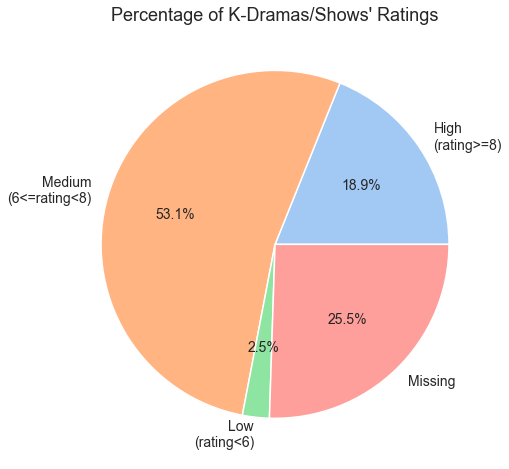

In [406]:
# Bin ratings into different range
conds = [
  data['Rating']>=8,
  (data['Rating']<8) & (data['Rating']>=6),
  data['Rating']<6
] #np.isnan(data['Rating'])
choices = [
  "High", "Medium", "Low"
]

df = data.copy()
df = df.assign(ratingCat = np.select(conds, choices, default="Missing"))
perct_rtngCat = df['ratingCat'].value_counts(normalize=True) * 100
perct_rtngCat = perct_rtngCat.reindex(['High','Medium','Low','Missing'])

# Plot pie chart
labels = ['High\n(rating>=8)','Medium\n(6<=rating<8)','Low\n(rating<6)','Missing'] #perct_rtngCat.index
colors = sns.color_palette('pastel')[0:len(perct_rtngCat)]
plt.figure(figsize=(8,8),facecolor='white')
plt.pie(
    perct_rtngCat.values, 
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    textprops={'fontsize': 14}
)
plt.title("Percentage of K-Dramas/Shows' Ratings")
plt.show()

del df

#### 3.2.2 Number of dramas/shows each year has

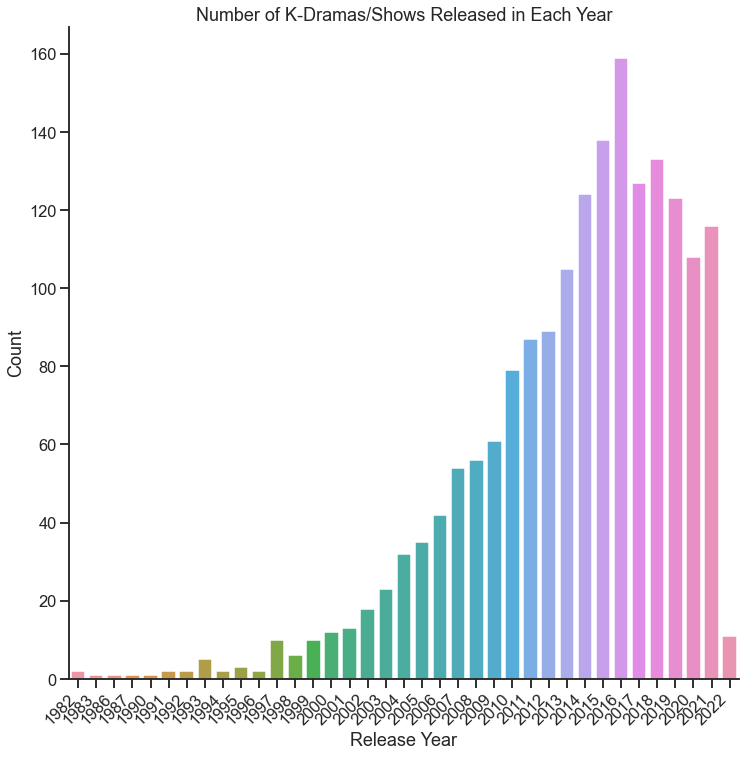

In [421]:
# Plot counts of shows for each released year
# Remove NaN values and convert the released year value to integer for better visualization
_df = data.copy()
_df = _df.dropna(subset=['YearRelease'])
_df['YearRelease'] = _df['YearRelease'].astype('int64')

fig, ax = plt.subplots(figsize=(12,12))
sns.countplot(x=_df['YearRelease'])
ax.set_xlabel("Release Year")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel("Count")
ax.set_title("Number of K-Dramas/Shows Released in Each Year")

sns.despine()
plt.show()
del _df

Upper and lower outlier threshold: 2030.00 and 1998.00, respectively


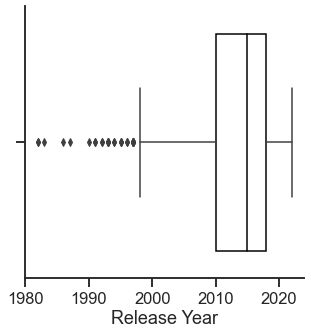

In [290]:
# Plot boxplot
# Remove NaN values and convert the released year value to integer for better visualization
_df = data.copy()
_df = _df.dropna(subset=['YearRelease'])
_df['YearRelease'] = _df['YearRelease'].astype('int64')

# Threshold of outliers
thresh_top = _df['YearRelease'].quantile(0.75) + 1.5 * iqr(_df['YearRelease'])
thresh_bot = _df['YearRelease'].quantile(0.25) - 1.5 * iqr(_df['YearRelease'])
print(
    "Upper and lower outlier threshold: {:.2f} and {:.2f}, respectively".format(
        thresh_top, thresh_bot
    )
)

fig, ax = plt.subplots(figsize=(5,5))
box = sns.boxplot(
    ax=ax, data=_df, x='YearRelease',
    linewidth=1.5,
    boxprops=dict(facecolor='none', edgecolor='black'),
    medianprops=dict(color='black')
)
ax.set_xlabel("Release Year")

sns.despine()
plt.show()

del _df

#### 3.2.3 Number of dramas/shows for each aired length

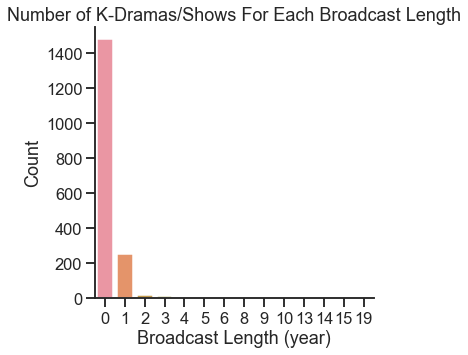

In [417]:
# Plot counts of shows for each nYears
# Remove NaN values and convert the nYears value to integer for better visualization
_df = data.copy()
_df = _df.dropna(subset=['nYears'])
_df['nYears'] = _df['nYears'].astype('int64')

fig, ax = plt.subplots(figsize=(5,5))
sns.countplot(x=_df['nYears'])
ax.set_xlabel("Broadcast Length (year)")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel("Count")
ax.set_title("Number of K-Dramas/Shows For Each Broadcast Length")

sns.despine()
plt.show()
del _df

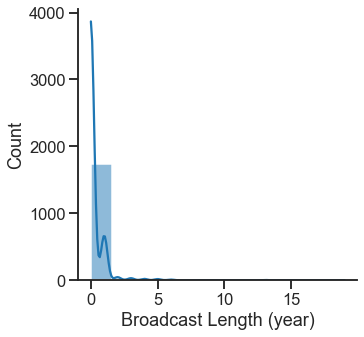

In [415]:
# Plot histogram
# Remove NaN values and convert the nYears value to integer for better visualization
_df = data.copy()
_df = _df.dropna(subset=['nYears'])
_df['nYears'] = _df['nYears'].astype('int64')

fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=_df, x='nYears', kde=True)
ax.set_xlabel('Broadcast Length (year)')
sns.despine()
plt.show()

del _df

Upper and lower outlier threshold: 0.00 and 0.00, respectively


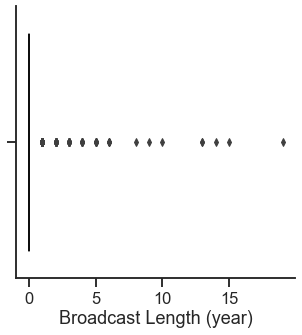

In [292]:
# Plot boxplot
# Remove NaN values and convert the nYears value to integer for better visualization
_df = data.copy()
_df = _df.dropna(subset=['nYears'])
_df['nYears'] = _df['nYears'].astype('int64')

# Threshold of outliers
thresh_top = _df['nYears'].quantile(0.75) + 1.5 * iqr(_df['nYears'])
thresh_bot = _df['nYears'].quantile(0.25) - 1.5 * iqr(_df['nYears'])
print(
    "Upper and lower outlier threshold: {:.2f} and {:.2f}, respectively".format(
        thresh_top, thresh_bot
    )
)

fig, ax = plt.subplots(figsize=(5,5))
box = sns.boxplot(
    ax=ax, data=_df, x='nYears',
    linewidth=1.5,
    boxprops=dict(facecolor='none', edgecolor='black'),
    medianprops=dict(color='black')
)
ax.set_xlabel("Broadcast Length (year)")

sns.despine()
plt.show()

del _df

In [293]:
# Plot a pie chart representing percentage
# Calculate the percentage of dramas/shows of each aired length
perct_nYears = data['nYears'].value_counts(normalize=True, dropna=False).sort_index() * 100
perct_nYears

0.0     82.085413
1.0     14.198558
2.0      0.998336
3.0      0.665557
4.0      0.443705
5.0      0.388242
6.0      0.221852
8.0      0.055463
9.0      0.055463
10.0     0.055463
13.0     0.110926
14.0     0.055463
15.0     0.055463
19.0     0.055463
NaN      0.554631
Name: nYears, dtype: float64

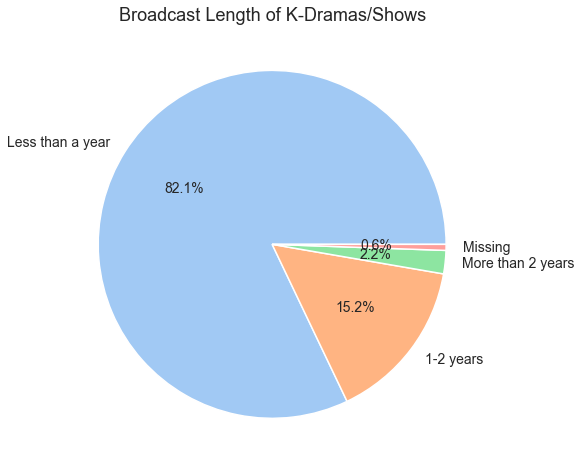

In [294]:
# percentage of dramas/shows aired for 1 or 2 years
perct_nYears_1or2 = perct_nYears[perct_nYears.index[1:3]].sum()

# percentage of dramas/shows aired for more than 2 years
perct_nYears_2More = perct_nYears[perct_nYears.index[3:len(perct_nYears)-1]].sum()

# percentage of data points with missing values
perct_nYears_nan = perct_nYears[perct_nYears.index[-1]]

# plot pie chart
perct_data = np.hstack(
    (perct_nYears[perct_nYears.index[0]], 
     perct_nYears_1or2,
     perct_nYears_2More,
     perct_nYears_nan)
)
labels = ["Less than a year", "1-2 years", "More than 2 years", "Missing"]
colors = sns.color_palette('pastel')[0:len(perct_data)]
plt.figure(figsize=(8,8), facecolor='white')
plt.pie(
    perct_data, 
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    textprops={'fontsize': 14}
)
plt.title("Broadcast Length of K-Dramas/Shows")
plt.show()

#### 3.2.4 Number of votes

Mean of Votes: 941.97


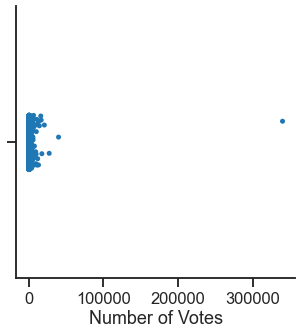

In [408]:
col = 'Votes'
print("Mean of {}: {:.2f}".format(col,data[col].mean()))

fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(data=data, x=col)
ax.set_xlabel('Number of Votes')
sns.despine()
plt.show()

Mean of Votes: 941.97


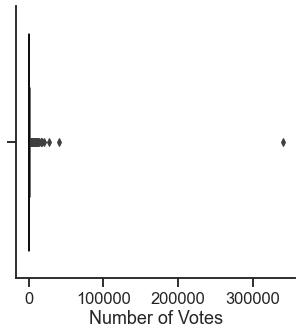

In [300]:
col = 'Votes'
print("Mean of {}: {:.2f}".format(col,data[col].mean()))

fig, ax = plt.subplots(figsize=(5,5))
box = sns.boxplot(
      ax=ax, data=data, x=col,
      linewidth=1.5,
      boxprops=dict(facecolor='none', edgecolor='black'),
      medianprops=dict(color='black')
  )
ax.set_xlabel('Number of Votes')
sns.despine()
plt.show()

In [301]:
# Number of votes
col = 'Votes'

thresh_top = data[col].quantile(0.75) + 1.5 * iqr(data[col].dropna())
print("{}: Upper threshold for outlier is {:.2f}".format(col, thresh_top))

Votes: Upper threshold for outlier is 1000.50


In [302]:
# Number of votes
# Which show receives a crazyly high number of votes?
data.loc[data['Votes']>50000]

,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
1,1,Squid Game,2021.0,0.0,8.1,339931.0,55.0,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",Hundreds of cash-strapped players accept a str...


In [303]:
data['Votes']

0        14032.0
1       339931.0
2        12877.0
3          921.0
4         1031.0
          ...   
1798         NaN
1799         5.0
1800        10.0
1801         NaN
1802         NaN
Name: Votes, Length: 1803, dtype: float64

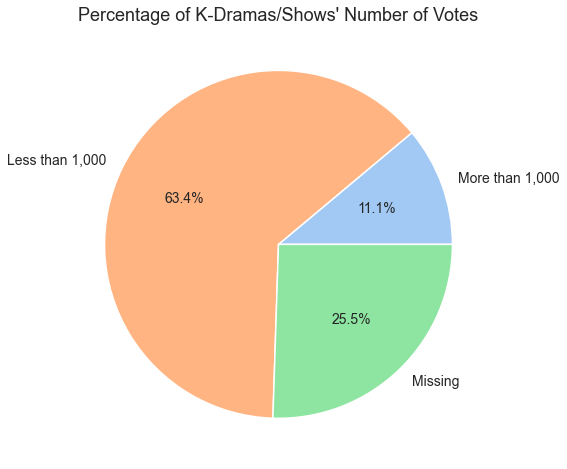

In [304]:
# Bin votes into different range
conds = [
  data['Votes']>=1000,
  data['Votes']<1000
] 
choices = ["More than 1,000", "Less than 1,000"]

df = data.copy()
df = df.assign(votesCat = np.select(conds, choices, default="Missing"))
perct_votesCat = df['votesCat'].value_counts(normalize=True) * 100
perct_votesCat = perct_votesCat.reindex(['More than 1,000','Less than 1,000','Missing'])

# Plot pie chart
labels = perct_votesCat.index
colors = sns.color_palette('pastel')[0:len(perct_votesCat)]
plt.figure(figsize=(8,8),facecolor='white')
plt.pie(
    perct_votesCat.values, 
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    textprops={'fontsize': 14}
)
plt.title("Percentage of K-Dramas/Shows' Number of Votes")
plt.show()

del df

#### 3.2.5 Episode length

Mean of Time: 57.20


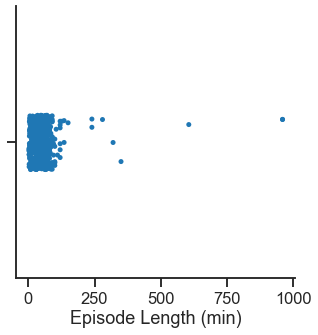

In [411]:
col = 'Time'
print("Mean of {}: {:.2f}".format(col,data[col].mean()))

fig, ax = plt.subplots(figsize=(5,5))
sns.stripplot(data=data, x=col)
ax.set_xlabel('Episode Length (min)')
sns.despine()
plt.show()

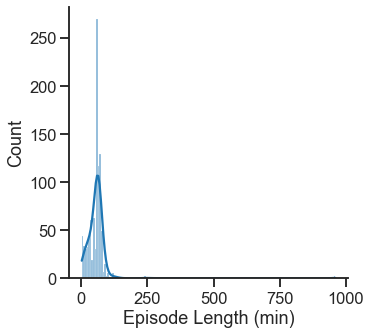

In [412]:
col = 'Time'

fig, ax = plt.subplots(figsize=(5,5))
sns.histplot(data=data, x=col, kde=True)
ax.set_xlabel('Episode Length (min)')
sns.despine()
plt.show()

Mean of Time: 57.20


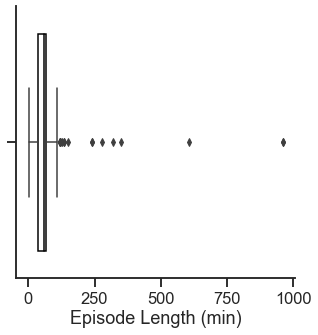

In [305]:
col = 'Time'

fig, ax = plt.subplots(figsize=(5,5))
box = sns.boxplot(
      ax=ax, data=data, x=col,
      linewidth=1.5,
      boxprops=dict(facecolor='none', edgecolor='black'),
      medianprops=dict(color='black')
  )
ax.set_xlabel('Episode Length (min)')
sns.despine()
plt.show()

In [306]:
# Episode length
# Which shows have long episode length that are considered as "outliers"?
col = 'Time'

thresh_top = data[col].quantile(0.75) + 1.5 * iqr(data[col].dropna())
# thresh_bot = data[col].quantile(0.25) - 1.5 * iqr(data[col].dropna())

print("{}: Upper threshold for outlier is {:.2f}".format(col, thresh_top))
data.loc[data[col]>thresh_top].sort_values(col, ascending=False)

Time: Upper threshold for outlier is 110.00


,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
1084,1197,Mr Duke,2000.0,0.0,7.2,15.0,960.0,Drama,"Seung-woo Kim, Choi Ji-woo, Gye-nam Myeong, By...",Jang Soo-jin is tricked into returning to Sout...
269,299,Nae ireumeun Kim Sam-soon,2005.0,0.0,8.0,1739.0,960.0,"Comedy, Drama, Romance","Kim Seon-a, Hyun Bin, Ryeowon Jung, Woon-gye Yeo",The misadventures and romantic entanglements o...
1733,1916,Tengoku no ki,2006.0,0.0,6.3,6.0,606.0,Drama,"Mire Aika, Reina Asami, Heung-soo Kim, Sonim",NaN
1228,1358,Golden Disc Awards,1986.0,0.0,8.6,13.0,350.0,Music,"BTS, Twice, Seventeen, Got7",The Golden Disc Awards is an annual South Kore...
1684,1864,Hanbamui regeyeonye,2017.0,0.0,NaN,NaN,320.0,Talk-Show,NaN,A passion and love for nothing other than regg...
897,993,Mnet Asian Music Awards,1999.0,0.0,6.8,13.0,280.0,Music,"BTS, EXO, Seventeen, Got7",The Mnet Asian Music Awards (abbreviated as MA...
1258,1389,Melon Music Awards,2009.0,0.0,7.6,5.0,240.0,Music,"BTS, Ji-eun Lee, Gfriend, Beast",The Melon Music Awards is a major music awards...
1724,1907,How are you.MOV,2018.0,0.0,NaN,NaN,240.0,Talk-Show,NaN,How are you.MOV is a music video review show h...
0,0,Hellbound,2021.0,0.0,6.7,14032.0,150.0,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",People hear predictions on when they will die....
1142,1263,Don't be the First One!,2020.0,0.0,NaN,NaN,135.0,Reality-TV,NaN,The plot of this show is filmed with hidden ca...


In [307]:
# It appears that the episode length of these dramas/shows are not the one for each episode, at least for some dramas
# For example, a quick Google search for the show "Nae ireumeun Kim Sam-soon" reveals that it has 16 episodes in total
# It is very likely that the time shown in the dataset is actually the total length of all 16 episodes
# That is, the correct episode length for this drama should be 960 mins / 16 = 60 mins, which is more reasonables

# However, it is not true for every drama above. 
# For instance, the "time" for the drama "Guardian: The Lonely and Great God" is 120 min in the data
# However, a Google search shows that its episode length varies between 60 and 90 min

# Interim summary: Results of any analysis on the "Time" variable needs to be interpreted with caution

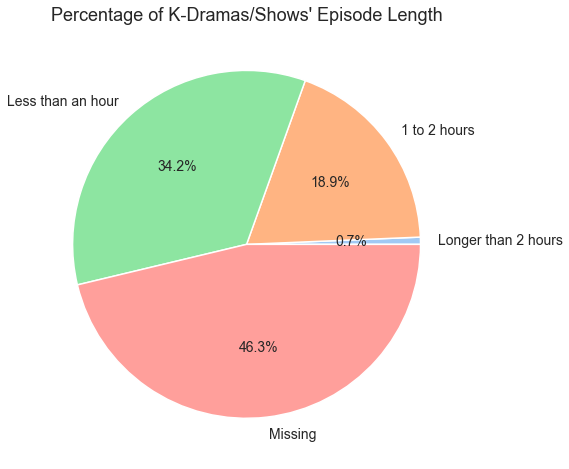

In [308]:
# Bin episode length into different range
conds = [
  data['Time']>120,
  (data['Time']<=120) & (data['Time']>60),
  data['Time']<=60
] 
choices = ["Longer than 2 hours", "1 to 2 hours", "Less than an hour"]

df = data.copy()
df = df.assign(timeCat = np.select(conds, choices, default="Missing"))
perct_timeCat = df['timeCat'].value_counts(normalize=True) * 100
perct_timeCat = perct_timeCat.reindex(["Longer than 2 hours", "1 to 2 hours", "Less than an hour", "Missing"])
perct_timeCat

# Plot pie chart
labels = perct_timeCat.index
colors = sns.color_palette('pastel')[0:len(perct_timeCat)]
plt.figure(figsize=(8,8), facecolor='white')
plt.pie(
    perct_timeCat.values, 
    labels=labels,
    colors=colors,
    autopct='%.1f%%',
    textprops={'fontsize': 14}
)
plt.title("Percentage of K-Dramas/Shows' Episode Length")
plt.show()

del df, labels, colors

### 3.3 Visualization of categorical variables

#### 3.3.1 Genre

In [309]:
# Unique genres across all data points
_s = data['Genre'].dropna()
genre_uniq = []
for idx, value in _s.iteritems():
    genres_list = value.split(',')
    genres_list = [g.strip() for g in genres_list]
    genre_uniq.extend(
        [g for g in genres_list if g not in genre_uniq]
    )

print("{} unique genre labels".format(len(genre_uniq)))
print(sorted(genre_uniq),)

25 unique genre labels
['Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Reality-TV', 'Romance', 'Sci-Fi', 'Short', 'Sport', 'Talk-Show', 'Thriller', 'War', 'Western']


In [310]:
# Tokenize genre labels across all data points
count_vect_genre = CountVectorizer(
    stop_words=None,
    token_pattern="(?u)\\b[\\w-]+\\b",
    lowercase=False
)

# Some data points don't have genre labels, replace them with whitespace 
# so that the CountVectorizer can work
genre_token = count_vect_genre.fit_transform(data['Genre'].fillna(' '))

# Put the results into a dataframe
df_genre_token = pd.DataFrame(
    genre_token.toarray(),
    columns=count_vect_genre.get_feature_names_out(),
    index=data.index
)
df_genre_token

,Action,Adventure,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,0,0,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1799,0,0,0,0,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
1800,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1801,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [311]:
# Count the number of genre labels across all K-dramas
nGenre_sort = df_genre_token.sum(axis=0).sort_values(ascending=False)
nGenre_sort

Drama          988
Romance        715
Comedy         459
Reality-TV     143
Fantasy        141
Action         131
Mystery        126
Crime           98
History         77
Thriller        75
Music           62
Family          45
Game-Show       37
Adventure       34
Talk-Show       32
Horror          22
Documentary     14
Sport           14
Sci-Fi          12
Biography       11
Musical          4
Short            4
War              4
News             3
Western          1
dtype: int64

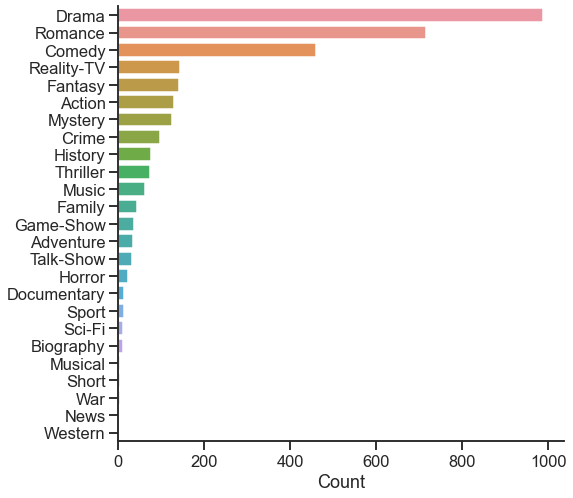

In [312]:
# Plot the number of genre labels across all K-dramas

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(y=nGenre_sort.index, x=nGenre_sort.values)
ax.set_xlabel('Count')
sns.despine()
plt.show()

# ax = nGenre_sort.plot(kind='barh', figsize=(5,5))
# ax.set_xlabel('Count')
# plt.show()

#### 3.3.2 Cast (actors/actresses)

In [313]:
# Unique actors/actress across all data points
_s = data['Stars'].dropna()
stars_uniq = []
for idx, value in _s.iteritems():
    stars_list = value.split(',')
    stars_list = [s.strip() for s in stars_list]
    stars_uniq.extend(
        [s for s in stars_list if s not in stars_uniq]
    )

print("{} unique actors/actresses".format(len(stars_uniq)))
print("Show the first 10 (sort alphabetically)")
print(sorted(stars_uniq)[:10],)

1965 unique actors/actresses
Show the first 10 (sort alphabetically)
['AOA', 'Ae Yun Jung', 'Ae-Yeon Jeong', 'Ah Jung Yoon', 'Ah-Hyeon Lee', 'Ah-yeon Oh', 'Ahn Bo-Hyun', 'Ahn Dong-Goo', 'Ahn Hyo-Seop', 'Ahn Jae-Hyun']


In [314]:
# Tokenize names of actors/actresses across all data points
# Create a custom tokenizer that separates names by comma 
# Note: when there is missing value (will be replaced as whitespace), not separate by comma
def comma_tokenizer(s):
    if s.isspace():
        return s.split()
    else:
        return [i.strip() for i in s.split(',')]
count_vect_stars = CountVectorizer(
    stop_words=None,
    tokenizer=comma_tokenizer,
    lowercase=False
) #token_pattern="(?u)([a-zA-Z]+-[a-zA-z]+ [a-zA-z]+)"

# Some data points don't have information of actors/actresses, replace them with whitespace 
# so that the CountVectorizer can work
stars_token = count_vect_stars.fit_transform(data['Stars'].fillna(' '))

# Put the results into a dataframe
df_stars_token = pd.DataFrame(
    stars_token.toarray(),
    columns=count_vect_stars.get_feature_names_out(),
    index=data.index
)
df_stars_token

,AOA,Ae Yun Jung,Ae-Yeon Jeong,Ah Jung Yoon,Ah-Hyeon Lee,Ah-yeon Oh,Ahn Bo-Hyun,Ahn Dong-Goo,Ahn Hyo-Seop,Ahn Jae-Hyun,...,Yunpeng Yue,Yuri Kwon,Yuria Haga,Yuzuha Oda,Yû Takahashi,Yûki Satô,Yûko Fueki,Yûko Takayama,Zhiwen Yang,da-Eun Jung
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1800,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [315]:
nStars_sort = df_stars_token.sum(axis=0).sort_values(ascending=False)
print("The top 10 actors/actresses has starred in the most K-dramas/shows:")
print("(sorted by the number of times in the dataset)")
nStars_sort.head(10)

The top 10 actors/actresses has starred in the most K-dramas/shows:
(sorted by the number of times in the dataset)


Lee Dong-Wook    21
Min Namkoong     18
Kim Hae-sook     17
Jang Hyuk        17
Jung Kyung-ho    16
Dong-geon Lee    15
Kim Hyun-joo     15
Tae-Hyun Cha     15
Jang Dong-Gun    14
Hee-chul Kim     14
dtype: int64

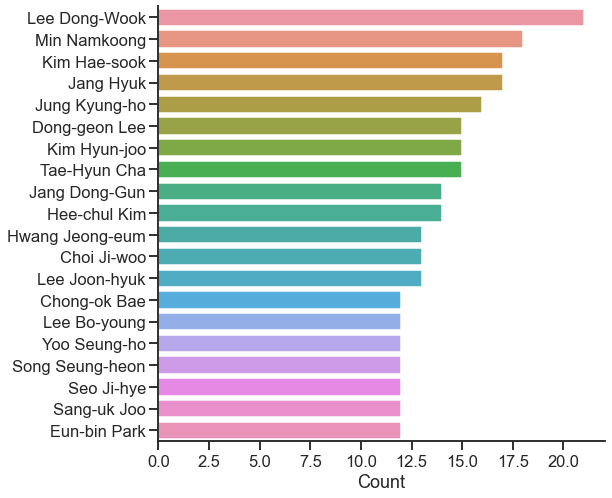

In [316]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(y=nStars_sort[:20].index, x=nStars_sort[:20].values)
ax.set_xlabel('Count')
sns.despine()
plt.show()

In [317]:
# Show the dramas/shows the top 1 actor/actress has starred
name_star = nStars_sort.index[0]
idx = data['Stars'].str.contains(name_star, na=False)
print("Average rating of K-dramas where {} is in (N={}): {:.2f} (SD={:.2f})".format(
    name_star,
    data.loc[idx,'Rating'].shape[0],
    data.loc[idx,'Rating'].mean(),
    data.loc[idx,'Rating'].std()
    )
)
data.loc[idx].sort_values('Rating', ascending=False)

Average rating of K-dramas where Lee Dong-Wook is in (N=21): 7.67 (SD=0.78)


,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
166,190,Baradeon Bada,2021.0,0.0,9.5,71.0,80.0,"Music, Reality-TV","Jong-shin Yoon, Ji-Ah Lee, Lee Dong-Wook, Onew",The cast members open a bar on the sea side an...
81,91,Bad and Crazy,2021.0,0.0,9.1,20.0,NaN,"Crime, Mystery","Lee Dong-Wook, Han Ji-Eun, Hak-Yeon Cha, Wi Ha...",A mystery drama in which detectives with diffe...
14,17,Guardian: The Lonely and Great God,2016.0,1.0,8.6,16487.0,120.0,"Comedy, Drama, Fantasy","Gong Yoo, Kim Go-eun, Lee Dong-Wook, Yoo In-Na",In his quest for a bride to break his immortal...
509,573,School,1999.0,0.0,8.1,593.0,NaN,"Drama, Mystery","Lee Dong-Wook, In-Sung Jo, Jae-Hyun Cho, Gye-n...",A popular high-school student completely chang...
1247,1378,Precious Family,2004.0,1.0,8.1,7.0,60.0,"Drama, Family","Eun-hee Bang, Lee Dong-Wook, Kim Hae-sook, Kim...",The drama shows how members of a good-natured ...
38,44,Tale of the Nine Tailed,2020.0,0.0,7.9,3306.0,70.0,"Fantasy, Horror, Romance","Lee Dong-Wook, Jo Bo-ah, Kim Bum, Kim Yong Ji",An urban dark fantasy drama about a gumiho who...
39,45,Hell Is Other People,2019.0,0.0,7.9,3395.0,60.0,"Crime, Horror, Mystery","Si-wan Yim, Lee Dong-Wook, Lee Jeong-eun, Hyun...",Unpleasant events disturb the life of an aspir...
464,524,Scent of a Woman,2011.0,0.0,7.9,472.0,NaN,"Drama, Romance","Kim Seon-a, Lee Dong-Wook, Ki-joon Uhm, Seo Hy...",Timid and considerate Yeon Jae finds out that ...
401,453,Mai geol,2005.0,1.0,7.8,1534.0,60.0,"Comedy, Drama, Romance","Lee Da-hae, Lee Dong-Wook, Lee Joon-Gi, Si-yeo...","With a perpetually indebted father, Joo Yoo Ri..."
772,858,The Fugitive of Joseon,2013.0,0.0,7.8,86.0,NaN,"Drama, History, Thriller","Lee Dong-Wook, Yoo Bin Kim, Song Ji-Hyo, Ji-Yo...","Set during the reign of King Injong, the prota..."


#### 3.3.3 Average rating for each genre

In [318]:
data_genre_token = data.join(df_genre_token)
data_genre_token = data_genre_token[['id','Title','Rating']+df_genre_token.columns.tolist()]
data_genre_token

,id,Title,Rating,Action,Adventure,Biography,Comedy,Crime,Documentary,Drama,...,News,Reality-TV,Romance,Sci-Fi,Short,Sport,Talk-Show,Thriller,War,Western
0,0,Hellbound,6.7,0,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,Squid Game,8.1,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,My Name,7.9,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Happiness,8.6,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,5,Dr. Brain,6.9,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,1984,Untitled K-Pop Latin American Project,NaN,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1799,1985,Bite Sisters,7.4,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1800,1986,Adult Trainee,7.1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1801,1987,A good supper,NaN,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [319]:
# Convert to long format
data_genre = data_genre_token.melt(
    id_vars=['id','Title'],
    value_vars=df_genre_token.columns,
    var_name='Genre',
    value_name='IsThisGenre'
)
data_genre

,id,Title,Genre,IsThisGenre
0,0,Hellbound,Action,0
1,1,Squid Game,Action,1
2,2,My Name,Action,1
3,4,Happiness,Action,1
4,5,Dr. Brain,Action,0
...,...,...,...,...
45070,1984,Untitled K-Pop Latin American Project,Western,0
45071,1985,Bite Sisters,Western,0
45072,1986,Adult Trainee,Western,0
45073,1987,A good supper,Western,0


In [320]:
# Merge ratings
data_genre_rtng = data_genre.merge(data[['id','Title','Rating']], on='id', how='left')
# Remove rows that the drama/show doesn't have that genre label (i.e., "IsThisGenre"=0)
data_genre_rtng = data_genre_rtng.loc[~(data_genre_rtng['IsThisGenre']==0)]
data_genre_rtng

,id,Title_x,Genre,IsThisGenre,Title_y,Rating
1,1,Squid Game,Action,1,Squid Game,8.1
2,2,My Name,Action,1,My Name,7.9
3,4,Happiness,Action,1,Happiness,8.6
6,8,Kingdom,Action,1,Kingdom,8.4
15,18,Mouse,Action,1,Mouse,8.7
...,...,...,...,...,...,...
42468,1103,Road No. 1,War,1,Road No. 1,8.6
42555,1202,Jeonwoo,War,1,Jeonwoo,8.4
42612,1264,Jingbirok,War,1,Jingbirok,7.0
42933,1612,Love and Ambition (Sarang gwa Yamang),War,1,Love and Ambition (Sarang gwa Yamang),NaN


In [321]:
print("Before removing NaN rows: {} unique genres".format(len(data_genre_rtng['Genre'].unique())))

# Remove rows with missing ratings
print(
    "After removing NaN rows: {} unique genres".format(
        len(data_genre_rtng.dropna(subset=['Rating'])['Genre'].unique())
    )
)

Before removing NaN rows: 25 unique genres
After removing NaN rows: 23 unique genres


In [322]:
print("Number of dramas/shows in each genre category")
print("(note: the sum won't be the total drama/shows in the dataset since each drama may have more than 1 genre label")
nDramas_genre = data_genre_rtng.dropna(subset=['Rating']).groupby('Genre').size().rename('nDramas')
nDramas_genre.sort_values(ascending=False)

Number of dramas/shows in each genre category
(note: the sum won't be the total drama/shows in the dataset since each drama may have more than 1 genre label


Genre
Drama          812
Romance        615
Comedy         406
Fantasy        132
Action         117
Mystery        115
Crime           89
Reality-TV      82
History         72
Thriller        66
Music           45
Adventure       29
Horror          20
Family          20
Game-Show       19
Talk-Show       10
Sci-Fi           9
Biography        9
Sport            8
Documentary      4
Short            3
War              3
Musical          2
Name: nDramas, dtype: int64

In [323]:
# Average rating for each genre
avgRtng_genre = data_genre_rtng.dropna(subset=['Rating']).groupby('Genre').agg(
    avgRtng=('Rating','mean')
)
# Add the nDramas column
avgRtng_genre = pd.concat(
    [avgRtng_genre, nDramas_genre],
    axis=1
)
avgRtng_genre.sort_values('avgRtng', ascending=False).round(2)

,avgRtng,nDramas
Genre,,
Documentary,8.35,4
Biography,8.29,9
Game-Show,8.20,19
Reality-TV,8.03,82
War,8.00,3
Family,7.83,20
History,7.80,72
Crime,7.71,89
Adventure,7.70,29


In [324]:
# # Plot the average rating for each genre (ordered from highest to lowest)
# # Remove rows with missing ratings
# df = data_genre_rtng.dropna(subset=['Rating'])

# fig, ax = plt.subplots(figsize=(10,10))
# sns.barplot(
#     data=df,
#     x='Genre',
#     y='Rating',
#     order=avgRtng_genre.sort_values('avgRtng', ascending=False).index,
#     ci=68
# )
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
# ax.set_title("Average Rating for Each Genre")

# sns.despine()
# plt.show()

# del df

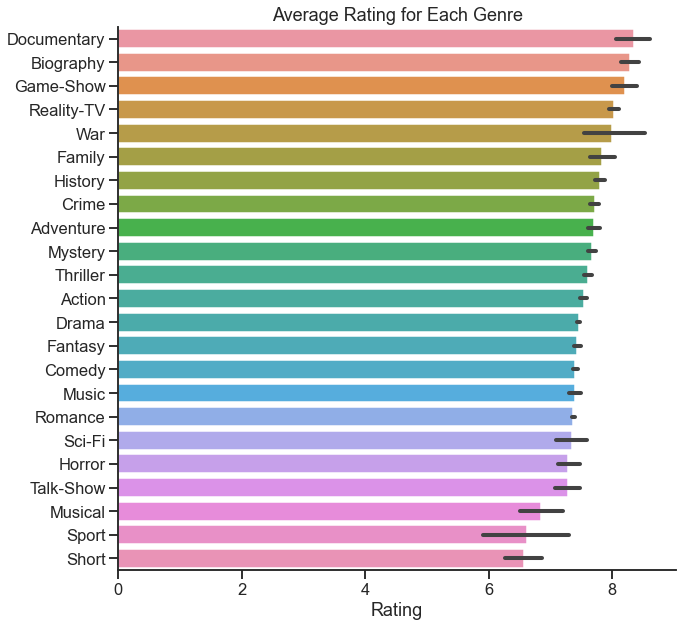

In [325]:
# Plot the average rating for each genre (ordered from highest to lowest)
# Horizontal bar graph

# Remove rows with missing ratings
df = data_genre_rtng.dropna(subset=['Rating'])

fig, ax = plt.subplots(figsize=(10,10))
sns.barplot(
    data=df,
    y='Genre',
    x='Rating',
    order=avgRtng_genre.sort_values('avgRtng', ascending=False).index,
    ci=68
)
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_ylabel("")
ax.set_title("Average Rating for Each Genre")

sns.despine()
plt.show()

del df

In [326]:
# Only show genres that have been assigned to more than 50 dramas/shows
idx = avgRtng_genre['nDramas'] > 50
avgRtng_genre_50dramas = avgRtng_genre.loc[idx]
print("{} genres has been assigned to more than 50 dramas/shows".format(avgRtng_genre_50dramas.shape[0]))
print("Their average ratings:")
avgRtng_genre_50dramas.sort_values('avgRtng', ascending=False).round(2)

10 genres has been assigned to more than 50 dramas/shows
Their average ratings:


,avgRtng,nDramas
Genre,,
Reality-TV,8.03,82
History,7.80,72
Crime,7.71,89
Mystery,7.67,115
Thriller,7.60,66
Action,7.53,117
Drama,7.45,812
Fantasy,7.43,132
Comedy,7.40,406


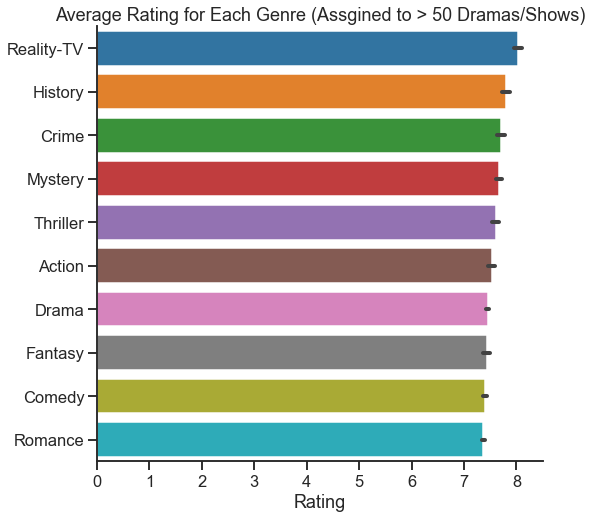

In [327]:
# Plot the average rating for each genre that has been assigned to more than 50 dramas/shows (ordered from highest to lowest)
# Horizontal bar graph

# Remove rows with missing ratings
df = data_genre_rtng.dropna(subset=['Rating'])
# Also, only include genre that has been assigned to more than 50 dramas/shows
idx = df['Genre'].isin(avgRtng_genre_50dramas.index)
df = df.loc[idx]

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(
    data=df,
    y='Genre',
    x='Rating',
    order=avgRtng_genre_50dramas.sort_values('avgRtng', ascending=False).index,
    ci=68
)
ax.set_ylabel("") # ax.set_ylabel("Cast")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Average Rating for Each Genre (Assgined to > 50 Dramas/Shows)")

sns.despine()
plt.show()

del df

#### 3.3.4 Average rating for each cast

In [328]:
data_stars_token = data.join(df_stars_token)
data_stars_token = data_stars_token[['id','Title','Rating']+df_stars_token.columns.tolist()]
data_stars_token

,id,Title,Rating,AOA,Ae Yun Jung,Ae-Yeon Jeong,Ah Jung Yoon,Ah-Hyeon Lee,Ah-yeon Oh,Ahn Bo-Hyun,...,Yunpeng Yue,Yuri Kwon,Yuria Haga,Yuzuha Oda,Yû Takahashi,Yûki Satô,Yûko Fueki,Yûko Takayama,Zhiwen Yang,da-Eun Jung
0,0,Hellbound,6.7,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,Squid Game,8.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,My Name,7.9,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,4,Happiness,8.6,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Dr. Brain,6.9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1798,1984,Untitled K-Pop Latin American Project,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1799,1985,Bite Sisters,7.4,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1800,1986,Adult Trainee,7.1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1801,1987,A good supper,NaN,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [329]:
# Convert to long format
data_stars = data_stars_token.melt(
    id_vars=['id','Title'],
    value_vars=df_stars_token.columns,
    var_name='Stars',
    value_name='PlayOrNot'
)
data_stars

,id,Title,Stars,PlayOrNot
0,0,Hellbound,AOA,0
1,1,Squid Game,AOA,0
2,2,My Name,AOA,0
3,4,Happiness,AOA,0
4,5,Dr. Brain,AOA,0
...,...,...,...,...
3541087,1984,Untitled K-Pop Latin American Project,da-Eun Jung,0
3541088,1985,Bite Sisters,da-Eun Jung,0
3541089,1986,Adult Trainee,da-Eun Jung,0
3541090,1987,A good supper,da-Eun Jung,0


In [330]:
# Merge ratings
data_stars_rtng = data_stars.merge(data[['id','Title','Rating']], on='id', how='left')

# Remove rows that the person doesn't play in the drama/show (i.e., "PlayOrNot"=0)
data_stars_rtng = data_stars_rtng.loc[~(data_stars_rtng['PlayOrNot']==0)]
data_stars_rtng

,id,Title_x,Stars,PlayOrNot,Title_y,Rating
1050,1158,Queendom,AOA,1,Queendom,8.1
1405,1547,Channel,AOA,1,Channel,5.3
1629,1800,One Fine Day,AOA,1,One Fine Day,7.3
2434,704,The Greatest Marriage,Ae Yun Jung,1,The Greatest Marriage,6.8
2690,982,Can We Get Married?,Ae Yun Jung,1,Can We Get Married?,6.8
...,...,...,...,...,...,...
3532643,635,Kamen Rider Kabuto,Yûki Satô,1,Kamen Rider Kabuto,7.9
3535315,1579,Bad Housewife,Yûko Fueki,1,Bad Housewife,8.0
3536493,900,Kamen Rider Wizard,Yûko Takayama,1,Kamen Rider Wizard,6.9
3538881,1536,Marriage Cuisine,Zhiwen Yang,1,Marriage Cuisine,8.3


In [331]:
print("Before removing NaN rows: {} unique cast".format(len(data_stars_rtng['Stars'].unique())))

# Remove rows with missing ratings
print(
    "After removing NaN rows: {} unique cast".format(
        len(data_stars_rtng.dropna(subset=['Rating'])['Stars'].unique())
    )
)

Before removing NaN rows: 1964 unique cast
After removing NaN rows: 1963 unique cast


In [332]:
print("Number of dramas/shows each cast has played")
print("(note: the sum won't be the total drama/shows in the dataset since each drama has more than 1 cast")
nDramas_stars = data_stars_rtng.dropna(subset=['Rating']).groupby('Stars').size().rename('nDramas')
nDramas_stars.sort_values(ascending=False)

Number of dramas/shows each cast has played
(note: the sum won't be the total drama/shows in the dataset since each drama has more than 1 cast


Stars
Lee Dong-Wook    21
Min Namkoong     18
Kim Hae-sook     17
Jang Hyuk        17
Jung Kyung-ho    16
                 ..
Jung-eun Hyun     1
Jung-eun Heo      1
Jung-an Chae      1
Jung-ah Yang      1
da-Eun Jung       1
Name: nDramas, Length: 1963, dtype: int64

In [333]:
# Average rating for each cast
avgRtng_stars = data_stars_rtng.dropna(subset=['Rating']).groupby('Stars').agg(
    avgRtng=('Rating','mean')
)
# Add the nDramas column
avgRtng_stars = pd.concat(
    [avgRtng_stars, nDramas_stars],
    axis=1
)
avgRtng_stars.sort_values('avgRtng', ascending=False).round(2)

,avgRtng,nDramas
Stars,,
Jisoo Kim,10.00,1
Lee Jung-hyun,10.00,1
Suga,9.50,1
Jin,9.36,5
Bo-Hee Lee,9.30,1
...,...,...
Mee-sook Kim,4.10,1
Bowie Lam,3.10,1
Lorena Kotô,3.10,1


In [334]:
# Only show cast who has played in more than 10 dramas/shows
idx = avgRtng_stars['nDramas'] > 10
avgRtng_stars_10dramas = avgRtng_stars.loc[idx]
print("{} cast has played in more than 10 dramas/shows".format(avgRtng_stars_10dramas.shape[0]))
print("Their average ratings:")
avgRtng_stars_10dramas.sort_values('avgRtng', ascending=False).round(2)

37 cast has played in more than 10 dramas/shows
Their average ratings:


,avgRtng,nDramas
Stars,,
Lee Seung-gi,8.01,12
Seong Ji,7.97,11
Jung Kyung-ho,7.96,16
Ji Chang-Wook,7.85,11
Han Ji-min,7.80,11
Lee Joon-hyuk,7.76,13
Lee Bo-young,7.74,12
Lee Dong-Wook,7.67,21
Kim Hae-sook,7.67,17


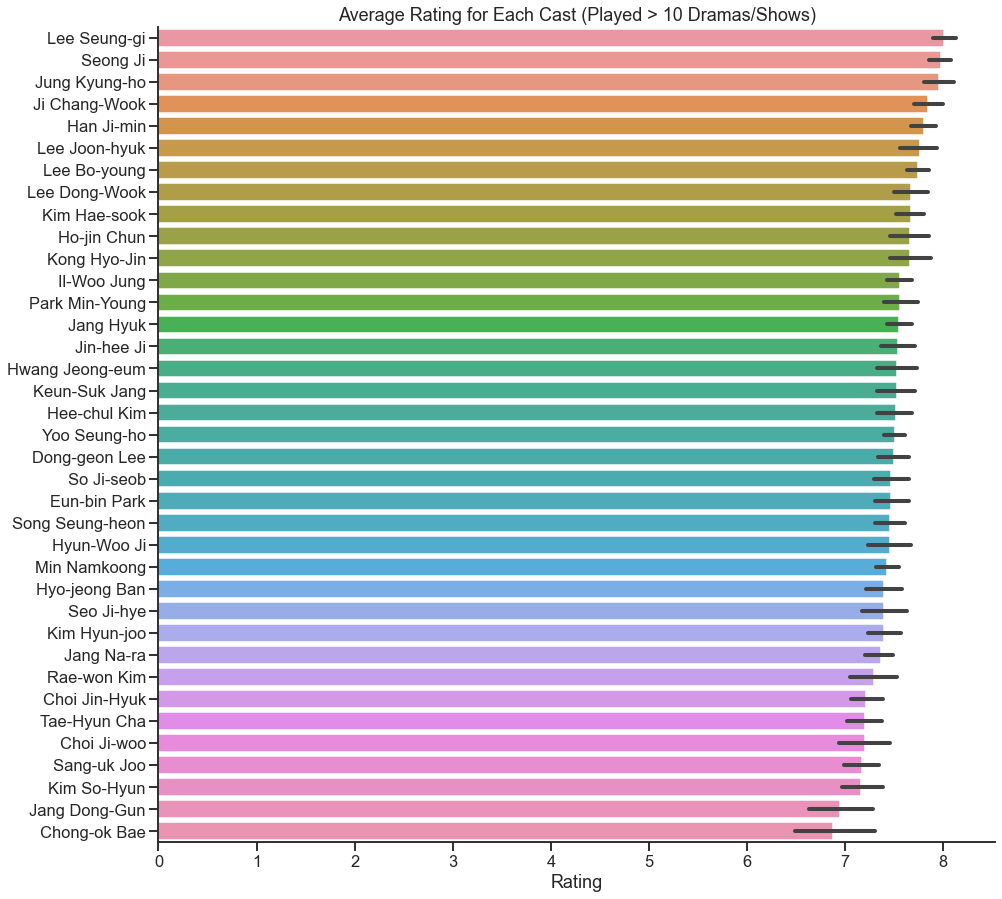

In [335]:
# Plot the average rating for each cast who has played in more than 10 dramas/shows (ordered from highest to lowest)
# Horizontal bar graph

# Remove rows with missing ratings
df = data_stars_rtng.dropna(subset=['Rating'])
# Also, only include cast who has played in more than 10 dramas/shows
idx = df['Stars'].isin(avgRtng_stars_10dramas.index)
df = df.loc[idx]

fig, ax = plt.subplots(figsize=(15,15))
sns.barplot(
    data=df,
    y='Stars',
    x='Rating',
    order=avgRtng_stars_10dramas.sort_values('avgRtng', ascending=False).index,
    ci=68
)
ax.set_ylabel("") # ax.set_ylabel("Cast")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Average Rating for Each Cast (Played > 10 Dramas/Shows)")

sns.despine()
plt.show()

del df

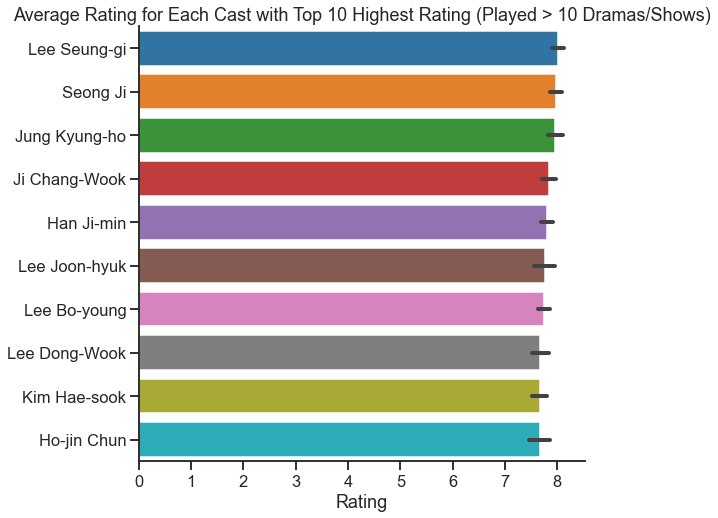

In [336]:
# For those played more than 10 dramas/shows, show cast with top 10 highest average ratings

# Remove rows with missing ratings
df = data_stars_rtng.dropna(subset=['Rating'])
# Also, only include cast who has played in more than 10 dramas/shows
idx = df['Stars'].isin(avgRtng_stars_10dramas.index)
df = df.loc[idx]

# Cast with top 10 highest average ratings
stars_avgRtng_top10 = avgRtng_stars_10dramas.sort_values('avgRtng', ascending=False).index[:10]
df = df.loc[df['Stars'].isin(stars_avgRtng_top10)]

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(
    data=df,
    y='Stars',
    x='Rating',
    order=stars_avgRtng_top10,
    ci=68
)
ax.set_ylabel("") # ax.set_ylabel("Cast")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Average Rating for Each Cast with Top 10 Highest Rating (Played > 10 Dramas/Shows)")

sns.despine()
plt.show()

del df

In [337]:
# Only show cast who has played in more than 15 dramas/shows
idx = avgRtng_stars['nDramas'] > 15
avgRtng_stars_15dramas = avgRtng_stars.loc[idx]
print("{} cast has played in more than 15 dramas/shows".format(avgRtng_stars_15dramas.shape[0]))
print("Their average ratings:")
avgRtng_stars_15dramas.sort_values('avgRtng', ascending=False).round(2)

5 cast has played in more than 15 dramas/shows
Their average ratings:


,avgRtng,nDramas
Stars,,
Jung Kyung-ho,7.96,16
Lee Dong-Wook,7.67,21
Kim Hae-sook,7.67,17
Jang Hyuk,7.55,17
Min Namkoong,7.43,18


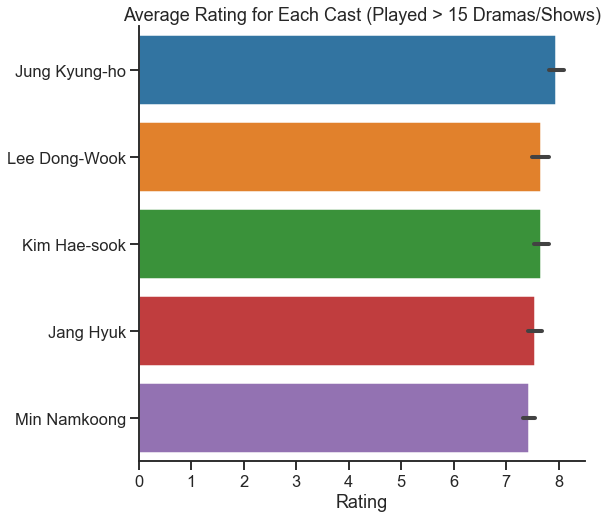

In [338]:
# Plot the average rating for each cast who has played in more than 15 dramas/shows (ordered from highest to lowest)
# Horizontal bar graph

# Remove rows with missing ratings
df = data_stars_rtng.dropna(subset=['Rating'])
# Also, only include cast who has played in more than 15 dramas/shows
idx = df['Stars'].isin(avgRtng_stars_15dramas.index)
df = df.loc[idx]

fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(
    data=df,
    y='Stars',
    x='Rating',
    order=avgRtng_stars_15dramas.sort_values('avgRtng', ascending=False).index,
    ci=68
)
ax.set_ylabel("") # ax.set_ylabel("Cast")
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.set_title("Average Rating for Each Cast (Played > 15 Dramas/Shows)")

sns.despine()
plt.show()

del df

## 4.Correlation

In [339]:
def prepData_corr(data,x,y):
    # Remove missing values from both x and y variables
    data_cln = data.dropna(subset=[x,y])
    return data_cln

In [340]:
def run_corr(data,x,y,method='pearson',showMsg=True):
    res = pg.corr(
        data[x].to_numpy(), data[y].to_numpy(),
        method=method
    )
    if showMsg:
        print(
            "r = {:.2f}; p = {:.3f}; 95%CI=[{},{}]".format(
                res['r'].values[0],
                res['p-val'].values[0],
                res['CI95%'].values[0][0],
                res['CI95%'].values[0][1]
            )
        )
    return res

### 4.1 Is rating related to when a K-drama/show is released?

Number of valid data points included in this analysis: 1343
r = 0.03; p = 0.254; 95%CI=[-0.02,0.08]


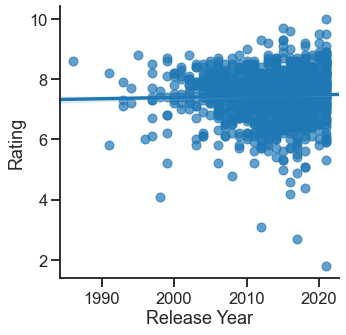

In [341]:
var_x = 'YearRelease'
var_y = 'Rating'

# df = data.dropna(subset=['Rating','YearRelease'])
df = prepData_corr(data, var_x, var_y)
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
# rVal, pVal = pearsonr(
#     df['Rating'].to_numpy(),
#     df['YearRelease'].to_numpy()
# )
# print("r = {:.2f}; p = {:.3f}".format(rVal, pVal))
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel('Release Year')
sns.despine()
plt.show()

del df

### 4.2 Is rating related to how long a K-drama/show is aired?

Number of valid data points included in this analysis: 1343
r = 0.06; p = 0.027; 95%CI=[0.01,0.11]


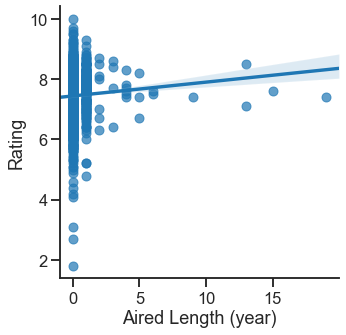

In [342]:
var_x = 'nYears'
var_y = 'Rating'

# df = data.dropna(subset=['Rating','nYears'])
df = prepData_corr(data, var_x, var_y)
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
# rVal, pVal = pearsonr(
#     df['Rating'].to_numpy(),
#     df['nYears'].to_numpy()
# )
# print("r = {:.2f}; p = {:.3f}".format(rVal, pVal))
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Aired Length (year)")
sns.despine()
plt.show()

del df

Number of valid data points included in this analysis: 1338
r = 0.09; p = 0.001; 95%CI=[0.04,0.14]


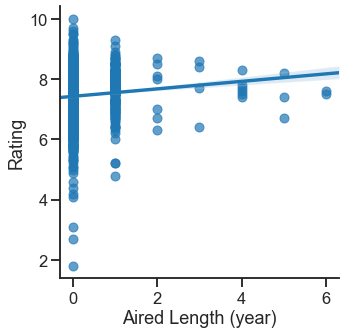

In [343]:
# The relationship could be affected by outliers with long aired time (nYears)
# Remove them and rerun the correlation
var_x = 'nYears'
var_y = 'Rating'

# Remove data points with nYears > 6
df = prepData_corr(data, var_x, var_y)
df = df.loc[~(df['nYears'] > 6)]

print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Aired Length (year)")
sns.despine()
plt.show()

del df

### 4.3 Is rating related to the number of votes (popularity)?

Number of valid data points included in this analysis: 1343
r = 0.05; p = 0.058; 95%CI=[-0.0,0.11]


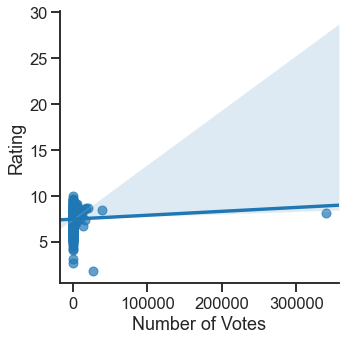

In [344]:
var_x = 'Votes'
var_y = 'Rating'

# df = data.dropna(subset=['Rating','Votes'])
df = prepData_corr(data, var_x, var_y)
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
# rVal, pVal = pearsonr(
#     df['Rating'].to_numpy(),
#     df['Votes'].to_numpy()
# )
# print("r = {:.2f}; p = {:.3f}".format(rVal, pVal))
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Number of Votes")
sns.despine()
plt.show()

del df

Number of valid data points included in this analysis: 1342
r = 0.13; p = 0.000; 95%CI=[0.08,0.18]


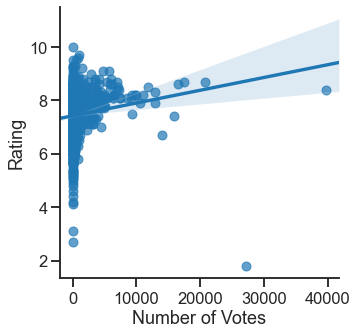

In [345]:
# This relationshp is likely affected by the extreme outlier (Squid Game)
var_x = 'Votes'
var_y = 'Rating'
# Remove that data point 
df = prepData_corr(data, var_x, var_y)
df = df.loc[~(df['Votes']>100000)]
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Number of Votes")
sns.despine()
plt.show()

del df

Number of valid data points included in this analysis: 1341
r = 0.13; p = 0.000; 95%CI=[0.08,0.18]


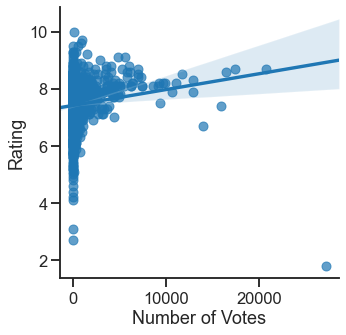

In [346]:
# Further remove the data point with roughly 40000 votes
# and remove the data point with low rating but with high votes
var_x = 'Votes'
var_y = 'Rating'
# Remove that data point 
df = prepData_corr(data, var_x, var_y)
df = df.loc[~(df['Votes']>100000)]
df = df.loc[~(df['Votes']>30000)]
# df = df.loc[~((df['Votes']>20000) & (df['Rating']<3))]
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Number of Votes")
sns.despine()
plt.show()

del df

Votes: Upper threshold for outlier is 1000.50
Number of valid data points included in this analysis: 1143
r = 0.12; p = 0.000; 95%CI=[0.06,0.17]


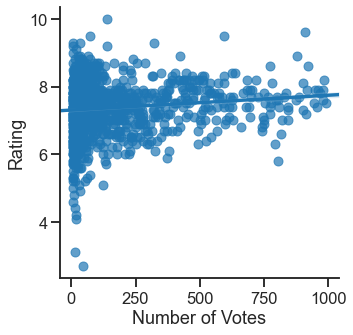

In [347]:
# How about removing outliers defined based on the boxplot?
var_x = 'Votes'
var_y = 'Rating'
df = prepData_corr(data, var_x, var_y)
thresh_top = df['Votes'].quantile(0.75) + 1.5 * iqr(df['Votes'])
print("Votes: Upper threshold for outlier is {:.2f}".format(thresh_top))

# Remove outliers
df = df.loc[~(df['Votes'] > thresh_top)]
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Number of Votes")
sns.despine()
plt.show()

del df

### 4.4 Is rating related to episode length?

Number of valid data points included in this analysis: 765
r = 0.08; p = 0.038; 95%CI=[0.0,0.15]


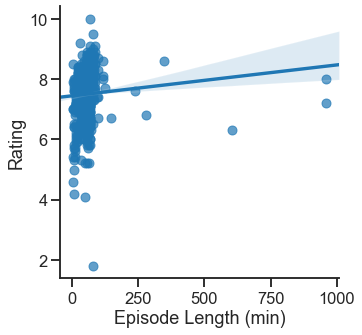

In [348]:
# df = data.dropna(subset=['Rating','Time'])
var_x = 'Time'
var_y = 'Rating'
df = prepData_corr(data, var_x, var_y)
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
# rVal, pVal = pearsonr(
#     df['Rating'].to_numpy(),
#     df['Time'].to_numpy()
# )
# print("r = {:.2f}; p = {:.3f}".format(rVal, pVal))
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Episode Length (min)")
sns.despine()
plt.show()

del df

In [430]:
# The relationship could be affected by some outliers
var_x = 'Time'
var_y = 'Rating'
df = prepData_corr(data, var_x, var_y)
df.loc[df['Time'] > 120]

,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
0,0,Hellbound,2021.0,0.0,6.7,14032.0,150.0,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",People hear predictions on when they will die....
269,299,Nae ireumeun Kim Sam-soon,2005.0,0.0,8.0,1739.0,960.0,"Comedy, Drama, Romance","Kim Seon-a, Hyun Bin, Ryeowon Jung, Woon-gye Yeo",The misadventures and romantic entanglements o...
897,993,Mnet Asian Music Awards,1999.0,0.0,6.8,13.0,280.0,Music,"BTS, EXO, Seventeen, Got7",The Mnet Asian Music Awards (abbreviated as MA...
1084,1197,Mr Duke,2000.0,0.0,7.2,15.0,960.0,Drama,"Seung-woo Kim, Choi Ji-woo, Gye-nam Myeong, By...",Jang Soo-jin is tricked into returning to Sout...
1155,1276,Kang Koo's Story,2014.0,0.0,7.7,19.0,127.0,Romance,"Lee Dong-Wook, Joo-mi Park",Kyung Tae (Lee Dong Wook) is cold-blooded and ...
1228,1358,Golden Disc Awards,1986.0,0.0,8.6,13.0,350.0,Music,"BTS, Twice, Seventeen, Got7",The Golden Disc Awards is an annual South Kore...
1258,1389,Melon Music Awards,2009.0,0.0,7.6,5.0,240.0,Music,"BTS, Ji-eun Lee, Gfriend, Beast",The Melon Music Awards is a major music awards...
1733,1916,Tengoku no ki,2006.0,0.0,6.3,6.0,606.0,Drama,"Mire Aika, Reina Asami, Heung-soo Kim, Sonim",NaN


Number of valid data points included in this analysis: 762
r = 0.21; p = 0.000; 95%CI=[0.14,0.28]


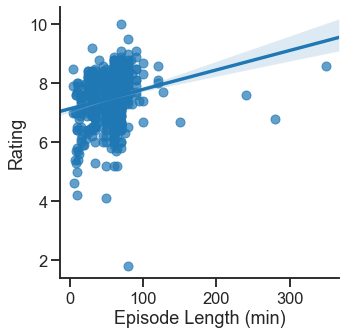

In [431]:
# It is unlikely that a drama has an episode length like 900ish mins
id_rm = [299, 1197, 1916] #[0, 299, 1197, 1276, 1916]
df = df.loc[~(df['id'].isin(id_rm))]

print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Episode Length (min)")
sns.despine()
plt.show()

del df

Time: Upper threshold for outlier is 92.50
Number of valid data points included in this analysis: 749
r = 0.26; p = 0.000; 95%CI=[0.19,0.32]


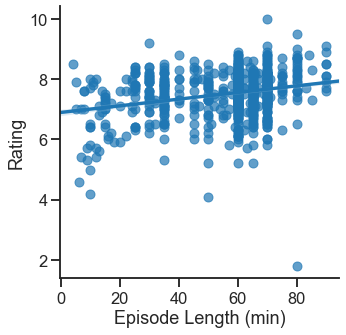

In [349]:
# The relationship could be affected by some outliers
var_x = 'Time'
var_y = 'Rating'
df = prepData_corr(data, var_x, var_y)

# Remove outliers defined based on the boxplot (Q3 + 1.5*IQR)
thresh_top = df['Time'].quantile(0.75) + 1.5 * iqr(df['Time'])
print("Time: Upper threshold for outlier is {:.2f}".format(thresh_top))

df = df.loc[~(df['Time'] > thresh_top)]
print("Number of valid data points included in this analysis: {}".format(df.shape[0]))

# Correlation
res = run_corr(df, var_x, var_y)

# Scatter plot with a regresssion line
fig, ax = plt.subplots(figsize=(5,5))
sns.regplot(
    data=df, x=var_x, y=var_y, 
    ci=68, truncate=False,
    scatter_kws={'alpha':0.7}
)
ax.set_xlabel("Episode Length (min)")
sns.despine()
plt.show()

del df

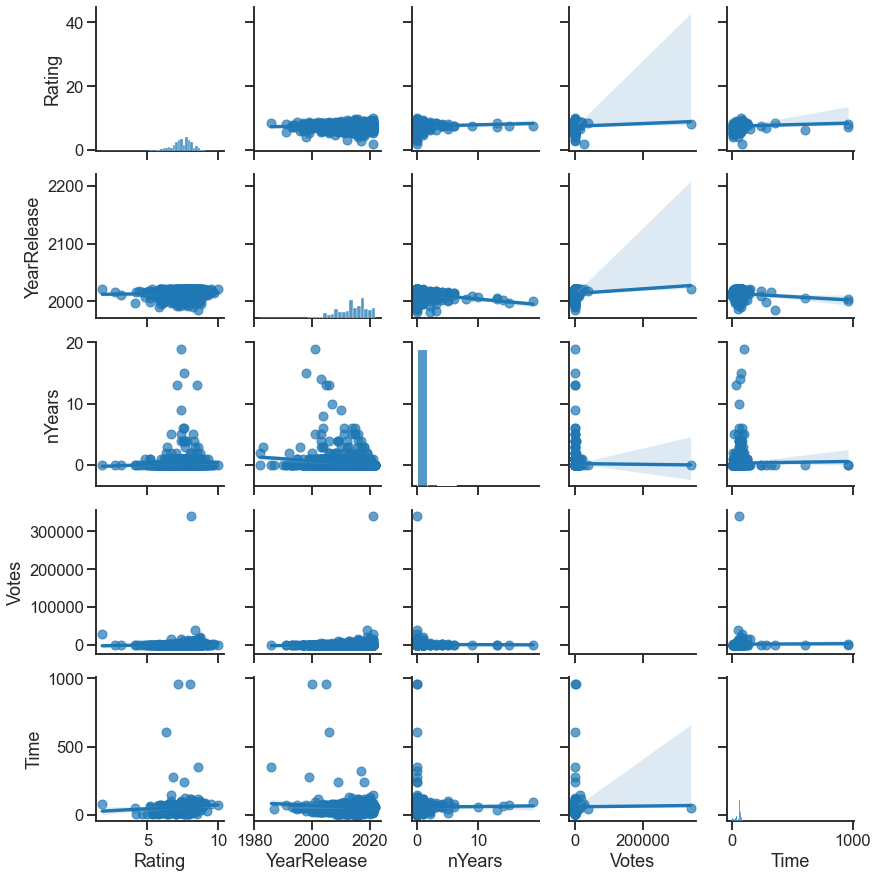

In [350]:
# Plot a pairplot showing relationships among the above variables
cols = ['Rating','YearRelease','nYears','Votes','Time']
df = data[cols]

# fig, ax = plt.subplots()
sns.pairplot(
    df, kind='reg',
    plot_kws={
        'scatter_kws': {'alpha': 0.7}
    }
)
plt.show()

del df

## 5.High-Rating K-Dramas/Shows
Focus on K-dramas/shows with high ratings and see
* What is the most popular genres?
* Who stars in these high-rating dramas/shows the most?

In [351]:
# Based on the boxplot of the rating, I decide to use the Q3 (75 percentile) score as the threshold for high-rating dramas/shows
thresh_highRtng = data['Rating'].quantile(0.75)
print("Focus on K-dramas/shows with ratings equal to or larger than {:.2f}".format(thresh_highRtng))

data_highRtng = data.loc[data['Rating']>=thresh_highRtng]
data_highRtng.info()

Focus on K-dramas/shows with ratings equal to or larger than 8.00
<class 'pandas.core.frame.DataFrame'>
Int64Index: 341 entries, 1 to 1662
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           341 non-null    int64  
 1   Title        341 non-null    object 
 2   YearRelease  341 non-null    float64
 3   nYears       341 non-null    float64
 4   Rating       341 non-null    float64
 5   Votes        341 non-null    float64
 6   Time         214 non-null    float64
 7   Genre        338 non-null    object 
 8   Stars        337 non-null    object 
 9   Short Story  318 non-null    object 
dtypes: float64(5), int64(1), object(4)
memory usage: 29.3+ KB


In [352]:
data_highRtng

,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
1,1,Squid Game,2021.0,0.0,8.1,339931.0,55.0,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",Hundreds of cash-strapped players accept a str...
3,4,Happiness,2021.0,0.0,8.6,921.0,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",An apocalyptic thriller that takes place in a ...
5,7,Hometown Cha-Cha-Cha,2021.0,0.0,8.6,6192.0,70.0,"Comedy, Romance","Shin Min-a, Kim Seon-Ho, Lee Bong-ryun, Kim Yo...",A big-city dentist opens up a practice in a cl...
6,8,Kingdom,2019.0,0.0,8.4,39773.0,45.0,"Action, Drama, History","Ju Ji-Hoon, Bae Doona, Kim Sungkyu, Hye-jun Kim",While strange rumors about their ill King grip...
8,10,Crash Landing on You,2019.0,1.0,8.7,20735.0,70.0,"Adventure, Comedy, Romance","Hyun Bin, Son Ye-jin, Seo Ji-hye, Kim Jung-hyun",The absolute top secret love story of a chaebo...
...,...,...,...,...,...,...,...,...,...,...
1557,1720,NCT Life in Osaka,2017.0,0.0,8.2,8.0,NaN,Reality-TV,"Doyoung, NCT, Taeil, Taeyong",Yuta takes in upon himself to be NCT's guide o...
1567,1730,Girls' Generation Goes to School,2007.0,0.0,8.1,22.0,NaN,Reality-TV,"Girls' Generation, Sungmin",The story of Girls' Generation's debut days.
1577,1743,Apink News,2011.0,0.0,8.1,20.0,NaN,Reality-TV,"Eun-ji Jung, Na-Eun Son, Bo-mi Yoon",A South Korean variety-documentary-reality typ...
1640,1815,The TaeTiSeo,2014.0,0.0,8.4,28.0,NaN,Reality-TV,"Taeyeon, Tiffany Hwang, Seohyun, Bo-ra Yoon",A look into the lives of the Girls' Generation...


### 5.1 Popular genres

In [353]:
# Unique genres among high-rating dramas
_s = data_highRtng['Genre'].dropna()
highRtng_genre_uniq = []
for idx, value in _s.iteritems():
    highRtng_genres_list = value.split(',')
    highRtng_genres_list = [g.strip() for g in highRtng_genres_list]
    highRtng_genre_uniq.extend(
        [g for g in highRtng_genres_list if g not in highRtng_genre_uniq]
    )

print("{} unique genre labels in high-rating dramas/shows".format(len(highRtng_genre_uniq)))
print(sorted(highRtng_genre_uniq),)

21 unique genre labels in high-rating dramas/shows
['Action', 'Adventure', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Game-Show', 'History', 'Horror', 'Music', 'Mystery', 'Reality-TV', 'Romance', 'Sci-Fi', 'Sport', 'Talk-Show', 'Thriller', 'War']


In [354]:
# Tokenize genre labels among high-rating dramas/shows
highRtng_count_vect_genre = CountVectorizer(
    stop_words=None,
    token_pattern="(?u)\\b[\\w-]+\\b",
    lowercase=False
)

# Some data points don't have genre labels, replace them with whitespace 
# so that the CountVectorizer can work
highRtng_genre_token = highRtng_count_vect_genre.fit_transform(data_highRtng['Genre'].fillna(' '))

# Put the results into a dataframe
df_highRtng_genre_token = pd.DataFrame(
    highRtng_genre_token.toarray(),
    columns=highRtng_count_vect_genre.get_feature_names_out(),
    index=data_highRtng.index
)
df_highRtng_genre_token

,Action,Adventure,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,Game-Show,...,Horror,Music,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War
1,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
6,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


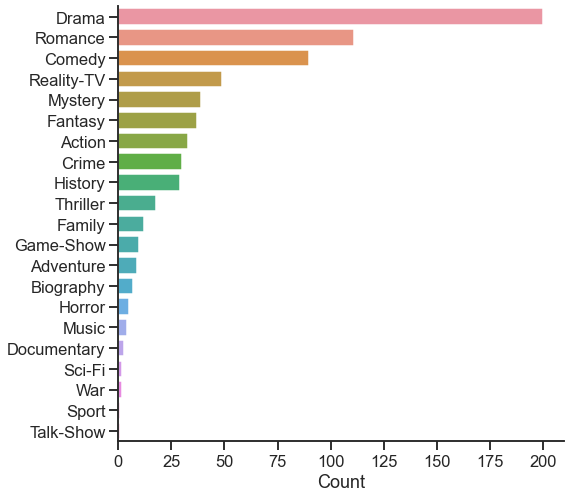

In [355]:
# Count the number of genre labels across high-rating K-dramas
highRtng_nGenre_sort = df_highRtng_genre_token.sum(axis=0).sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(y=highRtng_nGenre_sort.index, x=highRtng_nGenre_sort.values)
ax.set_xlabel('Count')
sns.despine()
plt.show()

### 5.2 Popular cast (actors/actresses)

In [356]:
# Unique actors/actress among high-rating dramas/shows
_s = data_highRtng['Stars'].dropna()
highRtng_stars_uniq = []
for idx, value in _s.iteritems():
    highRtng_stars_list = value.split(',')
    highRtng_stars_list = [s.strip() for s in highRtng_stars_list]
    highRtng_stars_uniq.extend(
        [s for s in highRtng_stars_list if s not in highRtng_stars_uniq]
    )

print("{} unique actors/actresses among high-rating dramas/shows".format(len(highRtng_stars_uniq)))
print("Show the first 10 (sort alphabetically)")
print(sorted(highRtng_stars_uniq)[:10],)

865 unique actors/actresses among high-rating dramas/shows
Show the first 10 (sort alphabetically)
['AOA', 'Ae-Yeon Jeong', 'Ah Jung Yoon', 'Ah-yeon Oh', 'Ahn Bo-Hyun', 'Ahn Jae-Hyun', 'Ahn Nae-sang', 'Ahn Suk-hwan', 'Alexander Lee', 'Amy Aleha']


In [357]:
# Tokenize names of actors/actresses among high-rating dramas/shows
# Create a custom tokenizer that separates names by comma 
# Note: when there is missing value (will be replaced as whitespace), not separate by comma
def comma_tokenizer(s):
    if s.isspace():
        return s.split()
    else:
        return [i.strip() for i in s.split(',')]
highRtng_count_vect_stars = CountVectorizer(
    stop_words=None,
    tokenizer=comma_tokenizer,
    lowercase=False
) #token_pattern="(?u)([a-zA-Z]+-[a-zA-z]+ [a-zA-z]+)"

# Some data points don't have information of actors/actresses, replace them with whitespace 
# so that the CountVectorizer can work
highRtng_stars_token = highRtng_count_vect_stars.fit_transform(data_highRtng['Stars'].fillna(' '))

# Put the results into a dataframe
df_highRtng_stars_token = pd.DataFrame(
    highRtng_stars_token.toarray(),
    columns=highRtng_count_vect_stars.get_feature_names_out(),
    index=data_highRtng.index
)
df_highRtng_stars_token

,AOA,Ae-Yeon Jeong,Ah Jung Yoon,Ah-yeon Oh,Ahn Bo-Hyun,Ahn Jae-Hyun,Ahn Nae-sang,Ahn Suk-hwan,Alexander Lee,Amy Aleha,...,Yun Ho Jung,Yun Ju-sang,Yun Se-ah,Yun-a Oh,Yun-hie Jo,Yun-shik Baek,Yuri Kwon,Yuria Haga,Yûko Fueki,Zhiwen Yang
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1567,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1577,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1640,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [358]:
highRtng_nStars_sort = df_highRtng_stars_token.sum(axis=0).sort_values(ascending=False)
print("The top 10 actors/actresses has starred in the most high-rating K-dramas/shows:")
print("(sorted by the number of times in the dataset)")
highRtng_nStars_sort.head(10)

The top 10 actors/actresses has starred in the most high-rating K-dramas/shows:
(sorted by the number of times in the dataset)


Jung Kyung-ho    10
Lee Joon-hyuk     8
Kim Hae-sook      8
Seong Ji          7
Lee Seung-gi      6
Lee Jong-Suk      6
Ho-jin Chun       6
Lee Dong-Wook     5
Jung Hae-In       5
Yeo Jin-gu        5
dtype: int64

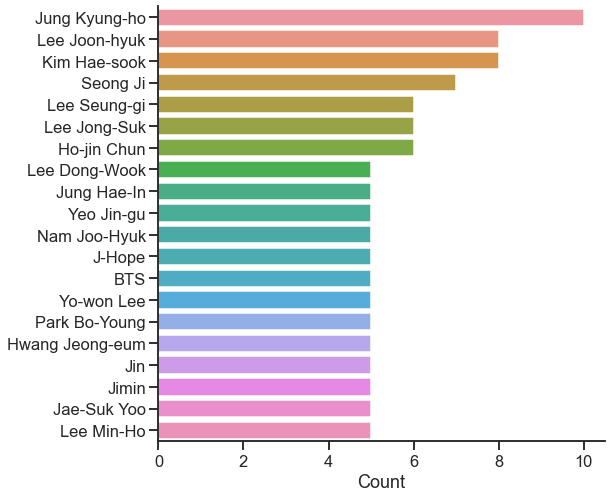

In [359]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.barplot(y=highRtng_nStars_sort[:20].index, x=highRtng_nStars_sort[:20].values)
ax.set_xlabel('Count')
sns.despine()
plt.show()

### 5.3 Common words in synposis

Generate a wordcloud representing the most frequent words

#### 5.3.1 For all kinds of genres

In [360]:
def story_preprocs(data, nlp, stopwords, col='Short Story'):
  # Remove rows with missing synopses
  data_cln = data.dropna(subset=[col])
  # print("Removing dramas/shows without synopses")
  print("{} of {} K-dramas/shows are included in this analysis".format(col, data_cln.shape[0]))

  # Remove punctuations (non-alphabet), remove stopwords, do lemmatization
  preprocs_story = [] # list of each drama's synopsis after lemmatization (a single sentence as a string)
  for doc in nlp.pipe(data_cln[col].tolist()):
      lemmas = [
          token.lemma_ for token in doc
          if token.lemma_.isalpha() and token.lemma_ not in stopwords
          ] 
      # lemmas_title.append(lemmas)
      preprocs_story.append(" ".join(lemmas))

  # A list of preprocessed story of each drama/show
  return preprocs_story

In [365]:
for row in data_highRtng['Short Story'].dropna().iteritems():
    print(row)

(1, "Hundreds of cash-strapped players accept a strange invitation to compete in children's games. Inside, a tempting prize awaits with deadly high stakes. A survival game that has a whopping 45.6 billion-won prize at stake.")
(3, 'An apocalyptic thriller that takes place in a time in which infectious diseases have become the new normal.')
(5, 'A big-city dentist opens up a practice in a close-knit seaside village, home to a charming jack-of-all-trades who is her polar opposite in every way.')
(6, 'While strange rumors about their ill King grip a kingdom, the crown prince becomes their only hope against a mysterious plague overtaking the land.')
(8, 'The absolute top secret love story of a chaebol heiress who made an emergency landing in North Korea because of a paragliding accident and a North Korean special officer who falls in love with her and who is hiding and protecting her.')
(9, 'A remake of the BBC drama "Criminal Justice" that delves into the criminal justice system through t

In [383]:
# It appears that the synposes of some dramas/shows were not fully extracted in 
# the original data. For these dramas/shows, there is "see full summary..." at 
# the end of the description. These words should be excluded since they are not 
# about the dramas/shows

# Also, an intuitive guess is that since the data contains K-dramas/shows,
# it is likely that the synopsis contains lots words like "Korea", "Korean",
# "South Korea", ..., etc. 
# These words are probably not informative and should be added to the stopwords list

# Add these words into the WorldCloud stopword list
wc_stopwords = set(STOPWORDS)
wc_stopwords.update(['see','full','summary', 'korea', 'korean', 'south'])
# print(wc_stopwords)

In [384]:
# Preprocess the text content in the synopsis
nlp = spacy.load('en_core_web_sm') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Run text preprocessing for each drama/show
preprocs_story = story_preprocs(data_highRtng, nlp, stopwords)

# Concatenate the preprocessed synopsis of each drama/show into a 
# big long "sentence"
preprocs_stories = " ".join(preprocs_story)
preprocs_stories

Short Story of 318 K-dramas/shows are included in this analysis


'cash strap player accept strange invitation compete child game inside tempting prize await deadly high stake survival game whopping billion win prize stake apocalyptic thriller place time infectious disease new normal big city dentist open practice close knit seaside village home charming jack trade polar opposite way strange rumor ill King grip kingdom crown prince hope mysterious plague overtake land absolute secret love story chaebol heiress emergency landing North Korea paragliding accident north korean special officer fall love hide protect remake BBC drama Criminal Justice delve criminal justice system story man surround woman murder story set Joseon Dynasty twin consider ominous sign Crown Princess Consort birth twin order send kill daughter save secretly send palace visit motherland korean italian mafia lawyer unrivaled conglomerate taste medicine justice extraordinary road emotional healing open selfish antisocial child book writer selfless psych ward caretaker cross path que

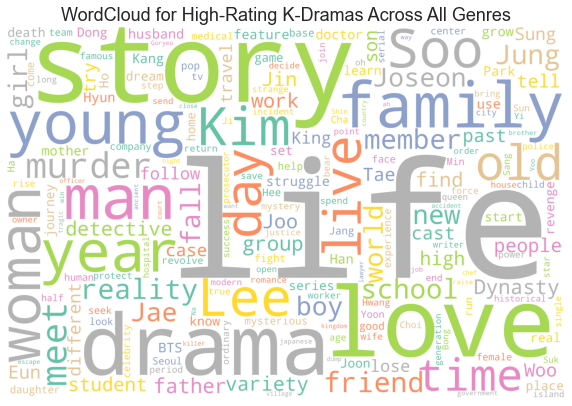

In [385]:
# Generage the wordcloud
wc = WordCloud(
    width = 3000, height = 2000, 
    random_state=0, background_color='white', 
    colormap='Set2', collocations=False,
    stopwords=wc_stopwords
)
wc.generate(preprocs_stories)

plt.figure(figsize=(10,10))
plt.title("WordCloud for High-Rating K-Dramas Across All Genres")
plt.imshow(wc) # interpolation="bilinear"
plt.axis('off')
plt.show()

#### 5.3.2 For Drama genre only

In [386]:
data_highRtng_genre_token = data_highRtng.join(df_highRtng_genre_token)
data_highRtng_genre_token = data_highRtng_genre_token[['id','Title','Rating','Short Story']+df_highRtng_genre_token.columns.tolist()]
data_highRtng_genre_token

,id,Title,Rating,Short Story,Action,Adventure,Biography,Comedy,Crime,Documentary,...,Horror,Music,Mystery,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War
1,1,Squid Game,8.1,Hundreds of cash-strapped players accept a str...,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,4,Happiness,8.6,An apocalyptic thriller that takes place in a ...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,7,Hometown Cha-Cha-Cha,8.6,A big-city dentist opens up a practice in a cl...,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
6,8,Kingdom,8.4,While strange rumors about their ill King grip...,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,10,Crash Landing on You,8.7,The absolute top secret love story of a chaebo...,0,1,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1557,1720,NCT Life in Osaka,8.2,Yuta takes in upon himself to be NCT's guide o...,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1567,1730,Girls' Generation Goes to School,8.1,The story of Girls' Generation's debut days.,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1577,1743,Apink News,8.1,A South Korean variety-documentary-reality typ...,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1640,1815,The TaeTiSeo,8.4,A look into the lives of the Girls' Generation...,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [387]:
# Select dramas/shows that have "Drama" label
data_highRtng_genre_token_drama = data_highRtng_genre_token.loc[~(data_highRtng_genre_token['Drama']==0)]
data_highRtng_drama = data_highRtng_genre_token_drama[['id','Title','Short Story','Drama']]
data_highRtng_drama

,id,Title,Short Story,Drama
1,1,Squid Game,Hundreds of cash-strapped players accept a str...,1
6,8,Kingdom,While strange rumors about their ill King grip...,1
11,13,The King's Affection,The story is set during the Joseon Dynasty whe...,1
12,15,Vincenzo,"During a visit to his motherland, a Korean-Ita...",1
13,16,It's Okay to Not Be Okay,An extraordinary road to emotional healing ope...,1
...,...,...,...,...
1393,1534,Jang-mit-bit In-saeng,NaN,1
1395,1536,Marriage Cuisine,"Archen had enough of her husband Yang Shu, and...",1
1420,1562,Beating Heart,Beating Heart (aka Six Love Stories) is a 12 e...,1
1435,1579,Bad Housewife,NaN,1


In [388]:
# Preprocess the text content in the synopsis
nlp = spacy.load('en_core_web_sm') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Run text preprocessing for each drama/show
preprocs_story_drama = story_preprocs(data_highRtng_drama, nlp, stopwords)

# Concatenate the preprocessed synopsis of each drama/show into a 
# big long "sentence"
preprocs_stories_drama = " ".join(preprocs_story_drama)
preprocs_stories_drama

Short Story of 190 K-dramas/shows are included in this analysis


'cash strap player accept strange invitation compete child game inside tempting prize await deadly high stake survival game whopping billion win prize stake strange rumor ill King grip kingdom crown prince hope mysterious plague overtake land story set Joseon Dynasty twin consider ominous sign Crown Princess Consort birth twin order send kill daughter save secretly send palace visit motherland korean italian mafia lawyer unrivaled conglomerate taste medicine justice extraordinary road emotional healing open selfish antisocial child book writer selfless psych ward caretaker cross path quest bride break immortal curse Dokkaebi year old guardian soul meet grim reaper sprightly student tragic past base novel tell record royal court romance King Joseon believe duty country love court lady want protect life choose bully discriminate ugly look high school girl transform gorgeous goddess quickly rise fame master art makeup online tutorial video ex con open street bar Itaewon seek revenge famil

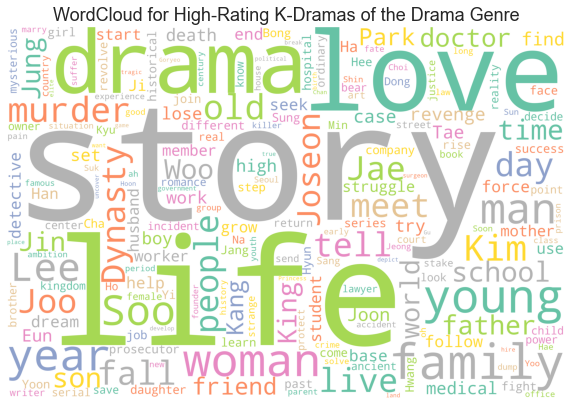

In [389]:
# Generage the wordcloud
wc_drama = WordCloud(
    width = 3000, height = 2000, 
    random_state=0, background_color='white', 
    colormap='Set2', collocations=False,
    stopwords=wc_stopwords
)
wc_drama.generate(preprocs_stories_drama)

plt.figure(figsize=(10,10))
plt.title("WordCloud for High-Rating K-Dramas of the Drama Genre")
plt.imshow(wc_drama) # interpolation="bilinear"
plt.axis('off')
plt.show()

#### 5.3.3 For Romance genre only

In [390]:
# Select dramas/shows that have "Romance" label
data_highRtng_genre_token_romance = data_highRtng_genre_token.loc[~(data_highRtng_genre_token['Romance']==0)]
data_highRtng_romance = data_highRtng_genre_token_romance[['id','Title','Short Story','Romance']]
data_highRtng_romance

,id,Title,Short Story,Romance
5,7,Hometown Cha-Cha-Cha,A big-city dentist opens up a practice in a cl...,1
8,10,Crash Landing on You,The absolute top secret love story of a chaebo...,1
11,13,The King's Affection,The story is set during the Joseon Dynasty whe...,1
13,16,It's Okay to Not Be Okay,An extraordinary road to emotional healing ope...,1
17,21,Red Sleeve,"Based on a novel of the same name, it tells th...",1
...,...,...,...,...
1264,1395,Give Love Away,The story of the second marriage of an older c...,1
1291,1424,A Wife's Credentials,Is this the life that you are meant to live? S...,1
1329,1465,White Lies,"A wealthy woman, Jung-Ok, pays a conniving nur...",1
1339,1476,Capital Scandal,This drama is set in the 1930's when Korea was...,1


In [391]:
# Preprocess the text content in the synopsis
nlp = spacy.load('en_core_web_sm') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Run text preprocessing for each drama/show
preprocs_story_romance = story_preprocs(data_highRtng_romance, nlp, stopwords)

# Concatenate the preprocessed synopsis of each drama/show into a 
# big long "sentence"
preprocs_stories_romance = " ".join(preprocs_story_romance)
preprocs_stories_romance

Short Story of 105 K-dramas/shows are included in this analysis


'big city dentist open practice close knit seaside village home charming jack trade polar opposite way absolute secret love story chaebol heiress emergency landing North Korea paragliding accident north korean special officer fall love hide protect story set Joseon Dynasty twin consider ominous sign Crown Princess Consort birth twin order send kill daughter save secretly send palace extraordinary road emotional healing open selfish antisocial child book writer selfless psych ward caretaker cross path base novel tell record royal court romance King Joseon believe duty country love court lady want protect life choose bully discriminate ugly look high school girl transform gorgeous goddess quickly rise fame master art makeup online tutorial video ex con open street bar Itaewon seek revenge family responsible father death young entrepreneur aspire launch virtual dream reality compete success love cutthroat world Korea high tech industry Flower Evil suspense melodrama man hide cruel past ch

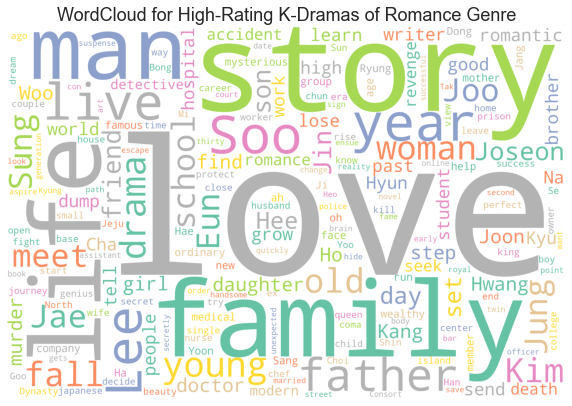

In [392]:
# Generage the wordcloud
wc_romance = WordCloud(
    width = 3000, height = 2000, 
    random_state=0, background_color='white', 
    colormap='Set2', collocations=False,
    stopwords=wc_stopwords
)
wc_romance.generate(preprocs_stories_romance)

plt.figure(figsize=(10,10))
plt.title("WordCloud for High-Rating K-Dramas of Romance Genre")
plt.imshow(wc_romance) # interpolation="bilinear"
plt.axis('off')
plt.show()

#### 5.3.4 For Comedy genre only

In [393]:
# Select dramas/shows that have "Comedy" label
data_highRtng_genre_token_comedy = data_highRtng_genre_token.loc[~(data_highRtng_genre_token['Comedy']==0)]
data_highRtng_comedy = data_highRtng_genre_token_comedy[['id','Title','Short Story','Comedy']]
data_highRtng_comedy

,id,Title,Short Story,Comedy
5,7,Hometown Cha-Cha-Cha,A big-city dentist opens up a practice in a cl...,1
8,10,Crash Landing on You,The absolute top secret love story of a chaebo...,1
12,15,Vincenzo,"During a visit to his motherland, a Korean-Ita...",1
13,16,It's Okay to Not Be Okay,An extraordinary road to emotional healing ope...,1
14,17,Guardian: The Lonely and Great God,In his quest for a bride to break his immortal...,1
...,...,...,...,...
1294,1429,Gag Concert,Gag Concert is a Korean sketch-comedy TV show ...,1
1339,1476,Capital Scandal,This drama is set in the 1930's when Korea was...,1
1395,1536,Marriage Cuisine,"Archen had enough of her husband Yang Shu, and...",1
1430,1573,Super Junior Full House,"Two female international students Anya ,a 20 y...",1


In [394]:
# Preprocess the text content in the synopsis
nlp = spacy.load('en_core_web_sm') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Run text preprocessing for each drama/show
preprocs_story_comedy = story_preprocs(data_highRtng_comedy, nlp, stopwords)

# Concatenate the preprocessed synopsis of each drama/show into a 
# big long "sentence"
preprocs_stories_comedy = " ".join(preprocs_story_comedy)
preprocs_stories_comedy

Short Story of 86 K-dramas/shows are included in this analysis


'big city dentist open practice close knit seaside village home charming jack trade polar opposite way absolute secret love story chaebol heiress emergency landing North Korea paragliding accident north korean special officer fall love hide protect visit motherland korean italian mafia lawyer unrivaled conglomerate taste medicine justice extraordinary road emotional healing open selfish antisocial child book writer selfless psych ward caretaker cross path quest bride break immortal curse Dokkaebi year old guardian soul meet grim reaper sprightly student tragic past bully discriminate ugly look high school girl transform gorgeous goddess quickly rise fame master art makeup online tutorial video young entrepreneur aspire launch virtual dream reality compete success love cutthroat world Korea high tech industry drama tell love story develop surgeon special force officer romance perfect narcissistic second generation heir capable assistant Bong soon woman bear superhuman strength come long

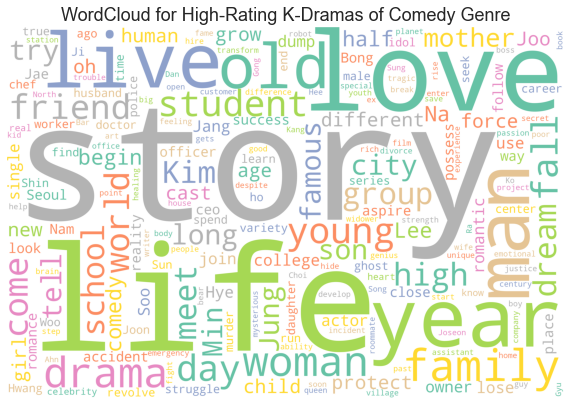

In [395]:
# Generage the wordcloud
wc_comedy = WordCloud(
    width = 3000, height = 2000, 
    random_state=0, background_color='white', 
    colormap='Set2', collocations=False,
    stopwords=wc_stopwords
)
wc_comedy.generate(preprocs_stories_comedy)

plt.figure(figsize=(10,10))
plt.title("WordCloud for High-Rating K-Dramas of Comedy Genre")
plt.imshow(wc_comedy) # interpolation="bilinear"
plt.axis('off')
plt.show()

#### 5.3.5 For Reality-TV shows

In [396]:
# Select dramas/shows that have "Reality-TV" label
data_highRtng_genre_token_reality = data_highRtng_genre_token.loc[~(data_highRtng_genre_token['Reality-TV']==0)]
data_highRtng_reality = data_highRtng_genre_token_reality[['id','Title','Short Story','Reality-TV']]
data_highRtng_reality

,id,Title,Short Story,Reality-TV
88,100,Running Man,Running Man is a reality-variety show where th...,1
94,106,In the SOOP BTS Ver.,The members of BTS enjoy the beauty of the SOO...,1
104,121,New World,"In this reality show, six celebs strategize an...",1
166,190,Baradeon Bada,The cast members open a bar on the sea side an...,1
307,340,Knowing Bros,Knowing Bros is a South Korean variety show wh...,1
341,383,BTS: Bon Voyage,BTS: Bon Voyage is a reality show about member...,1
358,403,I Live Alone,This show recollects the daily lives of celebr...,1
425,480,Three Meals a Day,South Korean cooking reality show. The cast li...,1
440,495,The Return of Superman,A variety/reality show in which four celebrity...,1
479,539,Twogether,Paired together for an unforgettable trip acro...,1


In [397]:
# Preprocess the text content in the synopsis
nlp = spacy.load('en_core_web_sm') 
stopwords = spacy.lang.en.stop_words.STOP_WORDS

# Run text preprocessing for each drama/show
preprocs_story_reality = story_preprocs(data_highRtng_reality, nlp, stopwords)

# Concatenate the preprocessed synopsis of each drama/show into a 
# big long "sentence"
preprocs_stories_reality = " ".join(preprocs_story_reality)
preprocs_stories_reality

Short Story of 42 K-dramas/shows are included in this analysis


'Running Man reality variety cast complete mission place win race member BTS enjoy beauty soop create schedule advance spend time enjoy hobby painting canoe seven spend time place reality celebs strategize sabotage earn virtual currency cash final day stay utopian island cast member open bar sea offer customer food drink musical act escape daily life moment Knowing Bros south korean variety feature main cast act student High School concept korean celebrity gueste Transfer Student BTS Bon Voyage reality member south korean boy band BTS Bangtan Sonyeondan travel everyday situation traveller encounter offer unique insight member life recollect daily life celebrity form unique sympathy single South Korea celebrity life significant filtering south korean cooking reality cast live little rural fishing village day week use food find create meal day summary variety reality celebrity dad return home week raise kid hour period help wife usually summary pair unforgettable trip Asia star Lee Seung

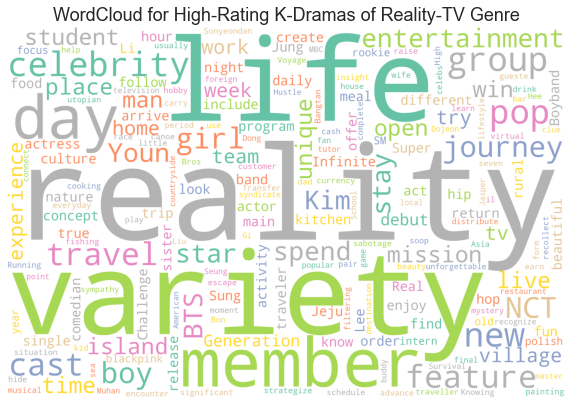

In [398]:
# Generage the wordcloud
wc_reality = WordCloud(
    width = 3000, height = 2000, 
    random_state=0, background_color='white', 
    colormap='Set2', collocations=False,
    stopwords=wc_stopwords
)
wc_reality.generate(preprocs_stories_reality)

plt.figure(figsize=(10,10))
plt.title("WordCloud for High-Rating K-Dramas of Reality-TV Genre")
plt.imshow(wc_reality) # interpolation="bilinear"
plt.axis('off')
plt.show()

## 6.Predict Ratings Using a Regression Model

In [433]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression, HuberRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.ensemble import IsolationForest

### 6.1 Data preprocessing

#### 6.1.1 Remove missing values

In [185]:
# Remove dramas/shows without ratings (missing values)
data_cln_rtng = data.dropna(subset=['Rating'])
print("{} of dramas in the dataset have ratings".format(data_cln_rtng.shape[0]))
data_cln_rtng

1343 of dramas in the dataset have ratings


,id,Title,YearRelease,nYears,Rating,Votes,Time,Genre,Stars,Short Story
0,0,Hellbound,2021.0,0.0,6.7,14032.0,150.0,"Crime, Drama, Fantasy","Yoo Ah-in, Kim Hyun-joo, Jeong Min Park, Jin-a...",People hear predictions on when they will die....
1,1,Squid Game,2021.0,0.0,8.1,339931.0,55.0,"Action, Drama, Mystery","Lee Jung-jae, Park Hae-soo, Wi Ha-Joon, Jung H...",Hundreds of cash-strapped players accept a str...
2,2,My Name,2021.0,0.0,7.9,12877.0,50.0,"Action, Crime, Drama","Hee-soon Park, Ahn Bo-Hyun, Han So-hee, Kim Sa...",The story about a woman who joins an organized...
3,4,Happiness,2021.0,0.0,8.6,921.0,NaN,"Action, Fantasy, Thriller","Han Hyo-joo, Park Hyung-Sik, Woo-jin Jo, Lee J...",An apocalyptic thriller that takes place in a ...
4,5,Dr. Brain,2021.0,0.0,6.9,1031.0,60.0,"Drama, Mystery, Sci-Fi","Sun-kyun Lee, June Yoon, Yoo-Young Lee, Hee-so...",Brilliant brain scientist Sewon (Lee Sun-Kyun)...
...,...,...,...,...,...,...,...,...,...,...
1714,1897,Yurihwa,2004.0,0.0,7.3,39.0,60.0,Drama,"Ha-neul Kim, Dong-geon Lee, Seong-su Kim, Yi-j...","During their childhood, Dong Joo and Gi Tae ar..."
1733,1916,Tengoku no ki,2006.0,0.0,6.3,6.0,606.0,Drama,"Mire Aika, Reina Asami, Heung-soo Kim, Sonim",NaN
1754,1938,Start Love,2015.0,0.0,5.0,5.0,10.0,"Comedy, Romance","Moon Byul, Jae-rok Kim, Kyu-jong Kim, Se-chang...",Start love is a romance drama of a man and a w...
1799,1985,Bite Sisters,2021.0,0.0,7.4,5.0,NaN,"Fantasy, Romance","Kang Han-na, Kim Yeong-Ah, Yu-hwa Choi, Lee Si...",This story follows Han Yi Na a vampire who sud...


In [186]:
# Select features to be included in the model and drop dramas with missing values
cols_feat = ['Votes','Time'] #'nYears',
col_tgt = 'Rating'
data_input = data_cln_rtng.dropna(subset=cols_feat)[cols_feat + [col_tgt]]
data_input

,Votes,Time,Rating
0,14032.0,150.0,6.7
1,339931.0,55.0,8.1
2,12877.0,50.0,7.9
4,1031.0,60.0,6.9
5,6192.0,70.0,8.6
...,...,...,...
1697,11.0,15.0,7.0
1709,16.0,50.0,7.7
1714,39.0,60.0,7.3
1733,6.0,606.0,6.3


#### 6.1.2 Remove outliers

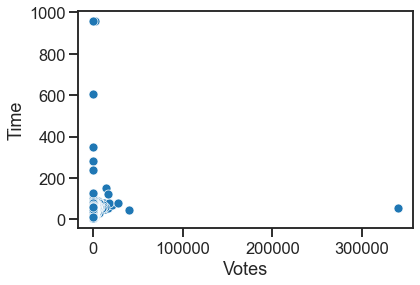

In [187]:
sns.scatterplot(data=data_input, x='Votes', y='Time')
plt.show()

In [188]:
# # Remove outliers based on IQR
# def rmOutlier_iqr(df, var):
#     thresh_top = df[var].quantile(0.75) + 1.5 * iqr(df[var])
#     thresh_bot = df[var].quantile(0.25) - 1.5 * iqr(df[var])
#     idx_keep = (df[var]<=thresh_top) & (df[var]>=thresh_bot)
#     df_cln = df.loc[idx_keep]
#     return df_cln

In [189]:
# # Remove outliers based on IQR
# vote_keep = rmOutlier_iqr(data_input, 'Votes')
# time_keep = rmOutlier_iqr(data_input, 'Time')

# idx_keep_vote = data_input.index.isin(vote_keep.index)
# idx_keep_time = data_input.index.isin(time_keep.index)

# data_input_cln = data_input.loc[idx_keep_vote & idx_keep_time]
# data_input_cln

In [190]:
# sns.scatterplot(data=data_input_cln, x='Votes', y='Time')
# plt.show()

In [191]:
# Use IsolationForest to detect outliers
isf = IsolationForest(n_estimators=100, random_state=0, contamination=0.02)

# Use fit_predict on the data 
pred_outlier = isf.fit_predict(data_input[cols_feat])

data_input = data_input.assign(
    isf_outliers=pred_outlier,
    isf_scores=isf.decision_function(data_input[cols_feat])
)
data_input['isf_outliers'] = data_input['isf_outliers'].astype(str)

# sns.scatterplot(data=data_input, 
#                 x='Votes', y='Time',
#                 hue='isf_outliers')
# # hue='isf_scores',
# plt.show()

print("{} outliers are detected and removed".format((data_input['isf_outliers']=='-1').sum()))
data_input_cln = data_input.loc[data_input['isf_outliers']=="1"]
print("{} samples are kept in the data".format(data_input_cln.shape[0]))
data_input_cln

16 outliers are detected and removed
749 samples are kept in the data


/opt/homebrew/Caskroom/miniforge/base/envs/kdrama-x64/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Votes,Time,Rating,isf_outliers,isf_scores
4,1031.0,60.0,6.9,1,0.264383
5,6192.0,70.0,8.6,1,0.106237
9,422.0,60.0,8.9,1,0.282114
15,3583.0,80.0,8.7,1,0.139585
16,748.0,60.0,7.8,1,0.267275
...,...,...,...,...,...
1692,6.0,40.0,7.3,1,0.241665
1697,11.0,15.0,7.0,1,0.203088
1709,16.0,50.0,7.7,1,0.266336
1714,39.0,60.0,7.3,1,0.290857


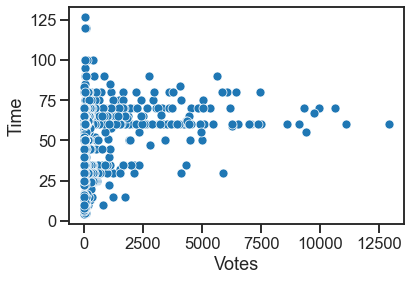

In [192]:
sns.scatterplot(data=data_input_cln, x='Votes', y='Time')
plt.show()

### 6.2 Split data into training and testing

In [182]:
# Features
X_data = data_input_cln.dropna(subset=cols_feat)[cols_feat]
# Target feature
y_data = data_input_cln.dropna(subset=cols_feat)[col_tgt]

In [193]:
# Split data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=0
)

# Convert to array
arr_X_train = X_train.to_numpy()
arr_X_test = X_test.to_numpy()
arr_y_train = y_train.to_numpy()
arr_y_test = y_test.to_numpy()

print("{} training samples".format(X_train.shape[0]))
print("{} left-out testing samples".format(X_test.shape[0]))

599 training samples
150 left-out testing samples


### 6.3 Base linear regression model

In [435]:
# Build a pipeline
pipe_linreg = Pipeline(
    steps=[
        ('std_scaler', StandardScaler()),
        ('reg', LinearRegression())
    ]
)

# Fit the training data
pipe_linreg.fit(X_train, y_train)

print("Coefficients:", pipe_linreg['reg'].coef_)
print("Intercept:", pipe_linreg['reg'].intercept_)

# Apply to the training data itself
y_train_pred = pipe_linreg.predict(X_train)

# Mean absolute error
mae_train = mean_absolute_error(y_train, y_train_pred)
print("Mean absolute error for the training data = {:.2f}".format(mae_train))

# Mean squared error
mse_train = mean_squared_error(y_train, y_train_pred, squared=True)
print("Mean squared error for the training data = {:.2f}".format(mse_train))

# Coefficient of determination on the training data
r2score_train = r2_score(y_train, y_train_pred)
print("Coefficient of determination for the training data = {:.2f}".format(r2score_train))
# print("Coefficient of determination for the training data = {:.2f}".format(
#     pipe_linreg['reg'].fit(arr_X_train, arr_y_train).score(arr_X_train, arr_y_train)
# ))

Coefficients: [0.20003054 0.17962219]
Intercept: 7.503839732888148
Mean absolute error for the training data = 0.51
Mean squared error for the training data = 0.46
Coefficient of determination for the training data = 0.15


In [438]:
# Apply the model to the testing data
y_pred = pipe_linreg.predict(X_test)

# Mean absolute error
mae_test = mean_absolute_error(y_test, y_pred)
print("Mean absolute error for the testing data = {:.2f}".format(mae_test))

# Mean squared error
mse_test = mean_squared_error(y_test, y_pred, squared=True)
print("Mean squared error for the testing data = {:.2f}".format(mse_test))

# Coeffcient of determination (r2 score)
r2score_test = r2_score(y_test, y_pred)
print("Coefficient of determination for the testing data = {:.2f}".format(r2score_test))

Mean absolute error for the testing data = 0.51
Mean squared error for the testing data = 0.42
Coefficient of determination for the testing data = 0.16


### 6.4 Huber Regression 
Robust to outliers

In [437]:
# Build a pipeline
pipe_huberreg = Pipeline(
    steps=[
        ('std_scaler', StandardScaler()),
        ('reg', HuberRegressor())
    ]
)

# Fit the training data
pipe_huberreg.fit(X_train, y_train)

print("Coefficients (Huber):", pipe_huberreg['reg'].coef_)
print("Intercept (Huber):", pipe_huberreg['reg'].intercept_)

# Apply to the training data itself
huber_y_train_pred = pipe_huberreg.predict(X_train)

# Mean absolute error
huber_mae_train = mean_absolute_error(y_train, huber_y_train_pred)
print("Mean absolute error for the training data (Huber) = {:.2f}".format(huber_mae_train))

# Mean squared error
huber_mse_train = mean_squared_error(y_train, y_train_pred, squared=True)
print("Mean squared error for the training data (Huber) = {:.2f}".format(huber_mse_train))

# Coefficient of determination on the training data
huber_r2score_train = r2_score(y_train, huber_y_train_pred)
print("Coefficient of determination for the training data (Huber) = {:.2f}".format(huber_r2score_train))

Coefficients (Huber): [0.17896784 0.13867126]
Intercept (Huber): 7.558112772299932
Mean absolute error for the training data (Huber) = 0.51
Mean squared error for the training data (Huber) = 0.46
Coefficient of determination for the training data (Huber) = 0.14


In [439]:
# Apply the model to the testing data
huber_y_pred = pipe_huberreg.predict(X_test)

# Mean absolute error
huber_mae_test = mean_absolute_error(y_test, huber_y_pred)
print("Mean absolute error for the testing data = {:.2f}".format(huber_mae_test))

# Mean squared error
huber_mse_test = mean_squared_error(y_test, huber_y_pred, squared=True)
print("Mean squared error for the testing data (Huber) = {:.2f}".format(huber_mse_test))

# Coeffcient of determination (r2 score)
huber_r2score_test = r2_score(y_test, huber_y_pred)
print("Coefficient of determination for the testing data (Huber) = {:.2f}".format(huber_r2score_test))

Mean absolute error for the testing data = 0.51
Mean squared error for the testing data (Huber) = 0.42
Coefficient of determination for the testing data (Huber) = 0.15


## 7. Regression Model Using Statsmodel

In [254]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
# # X = data_input_cln[cols_feat]
# X = sm.add_constant(data_input_cln[cols_feat])
# result = sm.OLS(data_input_cln[col_tgt], X).fit()
# print(result.summary())

In [548]:
data_input_cln.shape

(749, 5)

In [443]:
# Use R-style formula expression
model = smf.ols(formula='Rating ~ Votes + Time', data=data_input_cln)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                 Rating   R-squared:                       0.154
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     67.80
Date:                Wed, 22 Jun 2022   Prob (F-statistic):           8.82e-28
Time:                        18:49:35   Log-Likelihood:                -763.36
No. Observations:                 749   AIC:                             1533.
Df Residuals:                     746   BIC:                             1547.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8859      0.078     88.748      0.0

eval_env: 1


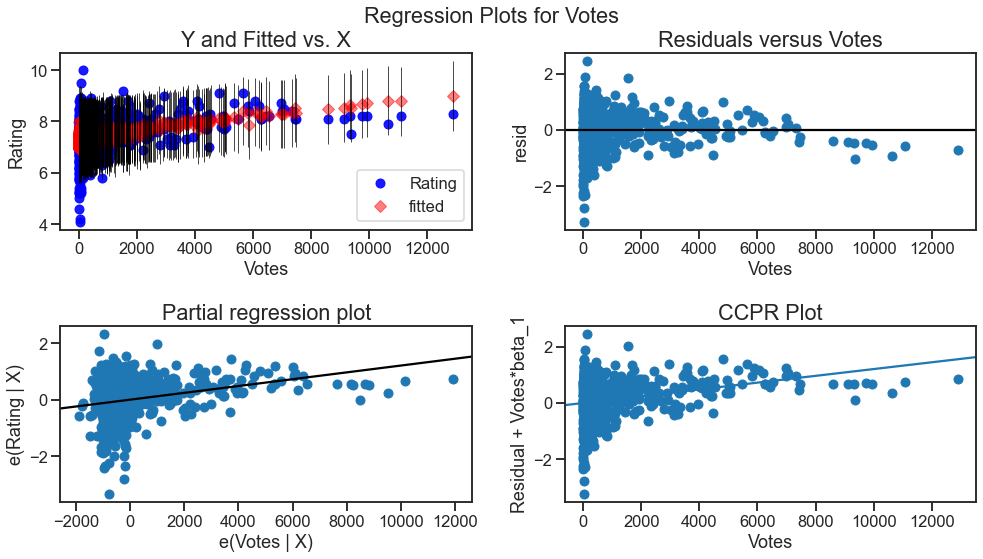

In [533]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(result, 'Votes', fig=fig)

eval_env: 1


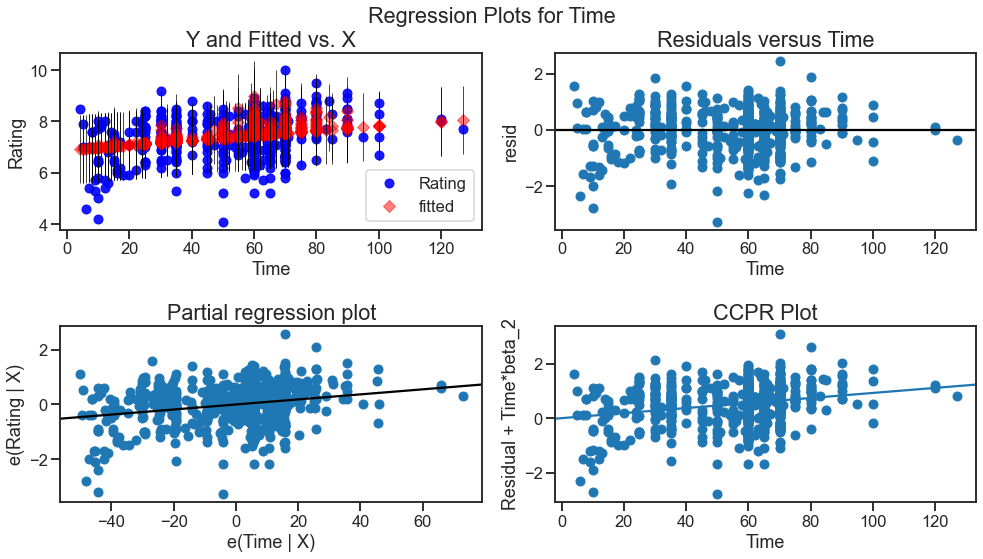

In [534]:
fig = plt.figure(figsize=(14, 8))
fig = sm.graphics.plot_regress_exog(result, 'Time', fig=fig)

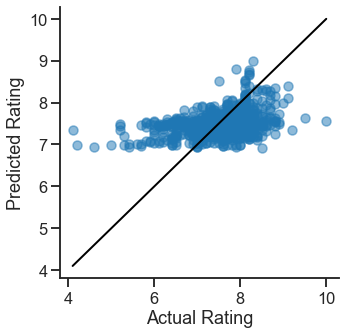

In [547]:
rtng_true = data_input_cln['Rating']
rtng_pred = result.predict(data_input_cln[['Votes','Time']])

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(x=rtng_true, y=rtng_pred, alpha=0.5)
ax.plot([rtng_true.min(), rtng_true.max()], [rtng_true.min(), rtng_true.max()], 'k-', lw=2)
ax.set_xlabel('Actual Rating')
ax.set_ylabel('Predicted Rating')

sns.despine()
plt.show()

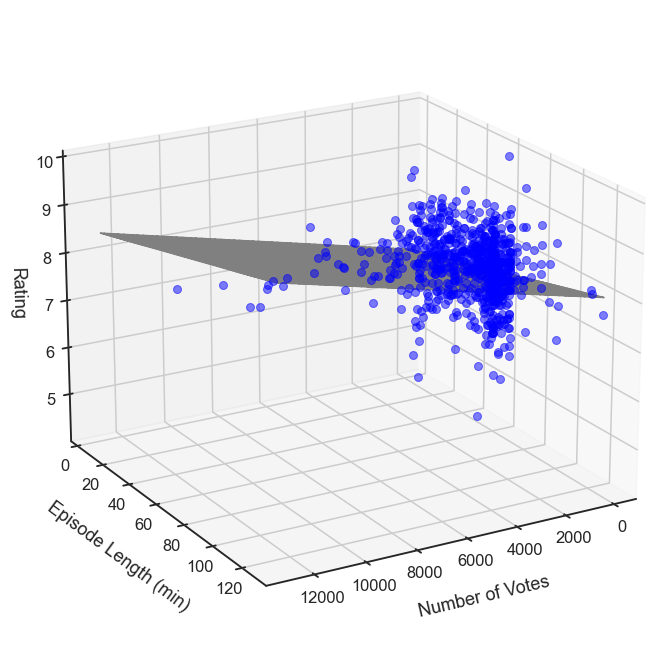

In [523]:
# Plot the regression plane 
x = np.linspace(data_input_cln['Votes'].min(), data_input_cln['Votes'].max(), 100)
y = np.linspace(data_input_cln['Time'].min(), data_input_cln['Time'].max(), 100)
x_surf, y_surf = np.meshgrid(x,y)

df_xysurf = pd.DataFrame({'Votes': x_surf.ravel(), 'Time': y_surf.ravel()})
pred_xysurf = result.predict(exog=df_xysurf)


fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(
    data_input_cln['Votes'], 
    data_input_cln['Time'], 
    data_input_cln['Rating'],
    color='blue',
    marker='o',
    linestyle='none',
    markersize=8,
    alpha=0.5
) 
ax.plot_surface(
    x_surf,
    y_surf,
    pred_xysurf.to_numpy().reshape(x_surf.shape),
    color='gray',
    edgecolor='gray',
    alpha=0.8,
    shade=False
) #color='gray', edgecolors='gray',
ax.set_xlabel("Number of Votes", labelpad=20)
ax.set_ylabel("Episode Length (min)", labelpad=20)
ax.set_zlabel("Rating", labelpad=10)

ax.view_init(elev=20, azim=60)
plt.show()

In [496]:
x_surf[0][1]

135.1919191919192

In [497]:
y_surf[0][1]

4.0

In [499]:
result.params

Intercept    6.885902
Votes        0.000121
Time         0.009242
dtype: float64

In [507]:
result.params['Intercept'] + result.params['Votes']*x_surf[20][31] + result.params['Time']*y_surf[20][31]

7.639796161324917

In [506]:
pred_xysurf.to_numpy().reshape(x_surf.shape)[20][31]

7.639796161324917

In [458]:
pred_xysurf.to_numpy().reshape(x_surf.shape)

(150, 150)

In [ ]:
np.reshape(pred_xysurf)